In [4]:
import matplotlib.pyplot as plt
import scanpy as sc
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.metrics import roc_auc_score, average_precision_score, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

from torch import nn
import torch
import torch.nn.functional as F
import h5py
from tqdm import tqdm
import pandas as pd
import numpy as np
from skimage.transform import resize

import torch.optim as optim
import torch.nn as nn
from torch.autograd import Variable
import warnings
warnings.filterwarnings("ignore")

# Images
main_path = '/mnt/cephfs/sharedscratch/users/fshahi/Projects/Histomorphological-Phenotype-Learning'
import sys
import os
sys.path.append(main_path)
from data_manipulation.data import Data
from models.clustering.correlations import *
from models.clustering.data_processing import *
from IPython.display import clear_output
clear_output()
import os

import warnings
warnings.filterwarnings("ignore")

In [3]:
# Resolution and fold for the tile clustering and slide representations.
resolution     = 2.0
fold_number    = 4
groupby        = 'leiden_%s' % resolution

# Folder run.
dataset     = 'Meso'
additional_dataset = 'TCGA_MESO'
meta_folder     = '750K'
matching_field  = 'slides'


# Pickle files.
folds_pickle = '{}/files/pkl_{}_he_test_train_slides.pkl'.format(main_path, dataset)

# Tile representation files.
h5_complete_path   = '{}/results/BarlowTwins_3/{}/h224_w224_n3_zdim128/hdf5_{}_he_complete_filtered_metadata.h5'.format(main_path, dataset, dataset)
h5_additional_path = '{}/results/BarlowTwins_3/{}/h224_w224_n3_zdim128/hdf5_{}_he_complete_filtered_metadata.h5'.format(main_path, additional_dataset, additional_dataset)
figure_path = main_path + '/workflow/figures/HPC_figures/'
os.makedirs(figure_path, exist_ok=True)
main_cluster_path = h5_complete_path.split('hdf5_')[0]
main_cluster_path = os.path.join(main_cluster_path, meta_folder)
adatas_path       = os.path.join(main_cluster_path, 'adatas')

435 HPC: 11
55 HPC: 9


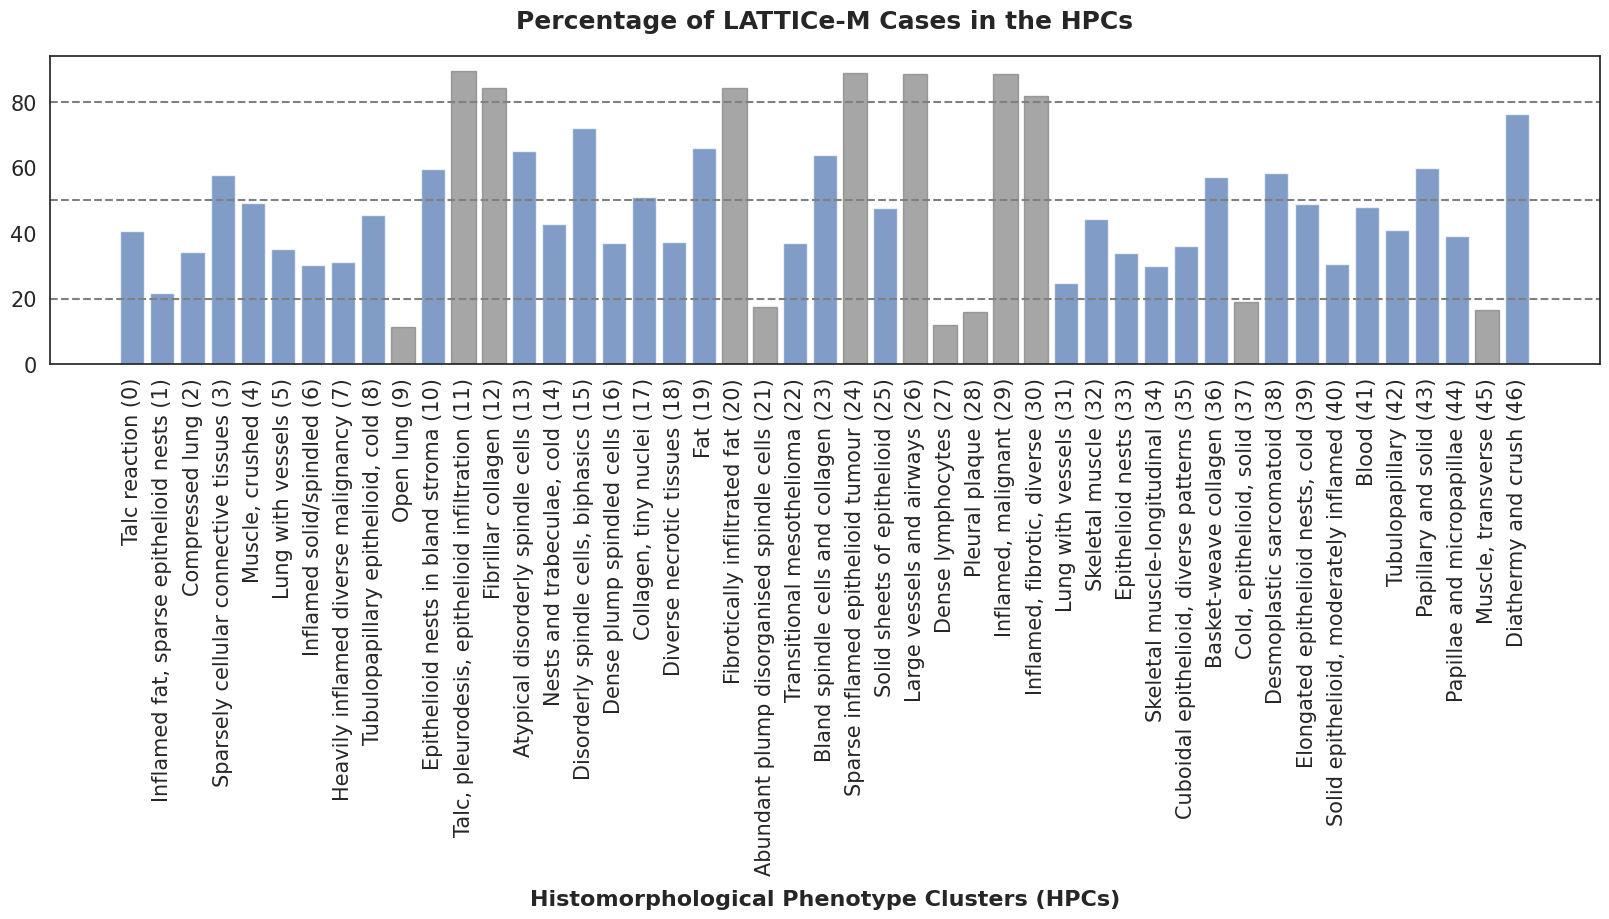

In [15]:
from skbio.stats.composition import clr_inv
meta_folder     = '750K'
df_train = pd.read_csv('{}/results/BarlowTwins_3/{}/h224_w224_n3_zdim128/{}/survival_csvs/clr_leiden_{}_fold{}_train_metadata.csv'.format(main_path, 'Meso', meta_folder , '2p0', 4), index_col=0)
df_test = pd.read_csv('{}/results/BarlowTwins_3/{}/h224_w224_n3_zdim128/{}/survival_csvs/clr_leiden_{}_fold{}_test_metadata.csv'.format(main_path, 'Meso', meta_folder , '2p0', 4), index_col=0)
annotations = pd.read_csv('{}/files/meso_annotations_750K.csv'.format(main_path), index_col=0).reset_index()


df_all = pd.concat([df_train, df_test])
leiden_clusters = [col for col in df_all.columns if col.isnumeric()]
inversed_df = pd.DataFrame(clr_inv(df_all[leiden_clusters]), columns=leiden_clusters)


sns.set_theme(style="white")
fig, ax = plt.subplots(figsize=(20,4))
hpc_df = inversed_df.copy()*100 
# at least 1% of case has the particular hpc: we call the patient HAS the HPC.
hpc_df = hpc_df > 1
hpc_df_percentages = hpc_df.astype(int).sum(axis=0)/hpc_df.shape[0]*100
# add hpc annotations to x labels
x_labels = []
for label in hpc_df_percentages.index.astype(int):
    text = annotations[annotations['HPC'] == label]['Summary'].values[0] + ' (' + str(label) + ')'
    x_labels.append(text)

ax.bar(x_labels, hpc_df_percentages.values, align='center')
plt.xticks(fontsize=15, rotation=90)
plt.yticks(fontsize=15);
ax.axhline(80, color='gray', linestyle='--')
ax.axhline(50, color='gray', linestyle='--')
ax.axhline(20, color='gray', linestyle='--')
ax.set_xlabel('Histomorphological Phenotype Clusters (HPCs)', fontsize=16, fontweight='bold', labelpad=10)
ax.set_title('Percentage of LATTICe-M Cases in the HPCs', fontsize=18, fontweight='bold', pad=20, loc='center')
for i, (v, bar) in enumerate(zip(hpc_df_percentages.values, ax.patches)):
    # if v == hpc_df_percentages.max():
    #     bar.set_alpha(1)
    if 20<v<80:
        bar.set_alpha(0.7)
    if v<20:
        # bar.set_alpha(0.3)
        bar.set_color('gray')
        bar.set_alpha(0.7)
    if v>80:
        bar.set_alpha(0.7)
        bar.set_color('gray')

print(hpc_df.sum().max(), 'HPC:', hpc_df.sum().idxmax())
print(hpc_df.sum().min(), 'HPC:', hpc_df.sum().idxmin())


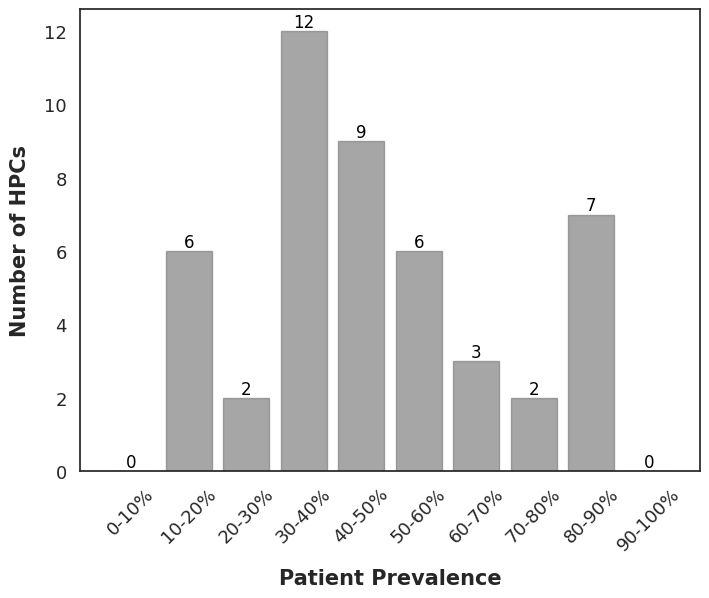

In [21]:
sns.set_theme(style="white")
# Bin the genes based on patient percentage
# binned = pd.cut(hpc_df_percentages, bins=[0, 20, 40, 60, 80, 100], labels=['0-20%', '20-40%', '40-60%', '60-80%', '80-100%'], include_lowest=True)
binned = pd.cut(hpc_df_percentages, bins=[0, 10,20,30, 40,50, 60,70, 80,90, 100], labels=['0-10%', '10-20%', '20-30%', '30-40%', '40-50%', '50-60%', '60-70%', '70-80%', '80-90%', '90-100%'], include_lowest=True)
binned_counts = binned.value_counts().sort_index()
fig, ax = plt.subplots(figsize=(8,6))
ax.bar(binned_counts.index, binned_counts.values, align='center', color='gray', alpha=0.7)
plt.xticks(fontsize=13, rotation=45);
plt.yticks(fontsize=13);
# ax.set_xlabel('Percentage of HPCs per patient', fontsize=16, fontweight='bold', labelpad=10)
ax.set_xlabel('Patient Prevalence', fontsize=15, fontweight='bold', labelpad=10)
# ax.set_title('Number of HPCs grouped by their percentages', fontsize=18, fontweight='bold', pad=20, loc='center')
ax.set_ylabel('Number of HPCs', fontsize=15, fontweight='bold', labelpad=10)
# ax.axhline(10, color='gray', linestyle='--')
# add the number on top of the bars
for i, (v, bar) in enumerate(zip(binned_counts.values, ax.patches)):
    bar.set_alpha(0.7)
    bar.set_color('gray')
    ax.annotate(str(v), (bar.get_x() + bar.get_width() / 2, v), ha='center', va='bottom', fontsize=12, color='black')
# ax.set_title('Percentage of LATTICe-M Cases in the HPCs', fontsize=18, fontweight='bold', pad=20, loc='center')

Text(0.5, 1.0, 'Number of patients with a HPC percentage > 50%')

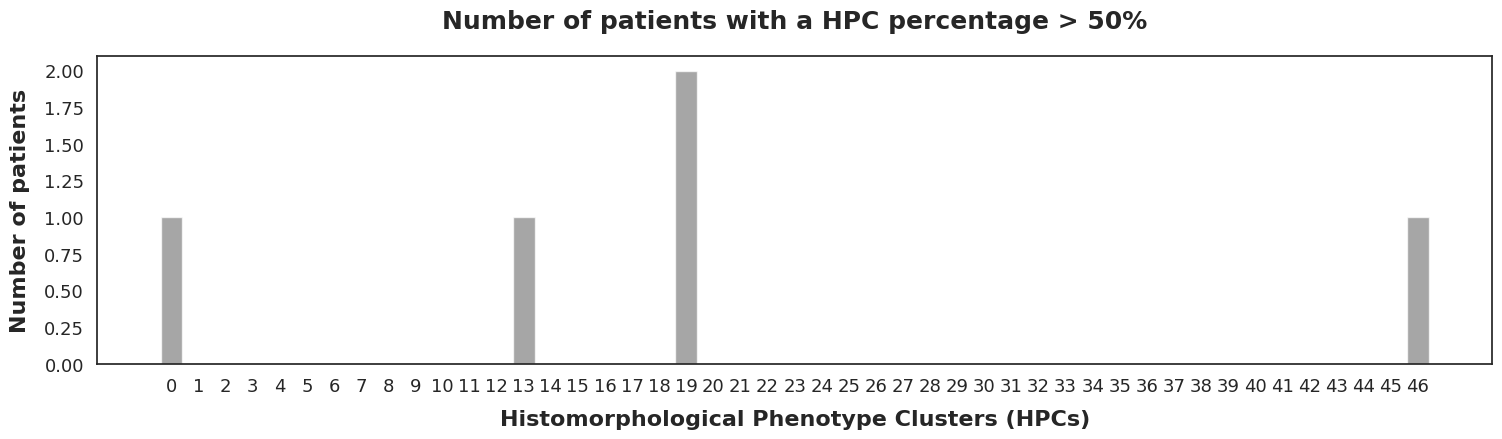

In [105]:
sns.set_theme(style="white")
fig, ax = plt.subplots(figsize=(18,4))
threshold = 50
hpc_df = inversed_df.copy()*100
temp = (hpc_df > threshold).sum(axis=0).astype(int)
ax.bar(temp.index, temp.values, align='center', color='gray', alpha=0.7)
plt.xticks(fontsize=13);
plt.yticks(fontsize=13);
ax.set_xlabel('Histomorphological Phenotype Clusters (HPCs)', fontsize=16, fontweight='bold', labelpad=10)
ax.set_ylabel('Number of patients', fontsize=16, fontweight='bold', labelpad=10)

ax.set_title('Number of patients with a HPC percentage > {}%'.format(threshold), fontsize=18, fontweight='bold', pad=20, loc='center')


#### Path-Annotation Agreement

In [2]:
import pandas as pd
import numpy as np

def clean_elements(x):
    xp = []
    for i in x:
        if not isinstance(i, float): 
            xp.append(i)
            xp = [x.strip() for x in xp]
    return xp


main_path = '/mnt/cephfs/sharedscratch/users/fshahi/Projects/Histomorphological-Phenotype-Learning'
figure_path = main_path + '/workflow/figures/HPC_figures/'
df1 = pd.read_excel(f'{main_path}/files/MM_cluster_annotation_form_v1_CR.xlsx', sheet_name='Sheet1', header=50, usecols='B:Y')
df1.iloc[-1, 0] = 46
df1.columns = [x+'_1' for x in df1.columns]
df1.rename(columns={'Cluster_1': 'HPC'}, inplace=True)

df2 = pd.read_excel(f'{main_path}/files/MM_cluster_annotation_form_v1_JLQ.xlsx', sheet_name='Sheet1', header=50, usecols='B:Y')
df2.columns = [x+'_2' for x in df2.columns]
df2.rename(columns={'Cluster_2': 'HPC'}, inplace=True)

df3 = pd.read_excel(f'{main_path}/files/MM_cluster_annotation_form_v1_SK.xlsx', sheet_name='Sheet1', header=50, usecols='B:Y')
df3.columns = [x+'_3' for x in df3.columns]
df3.rename(columns={'Cluster_3': 'HPC'}, inplace=True)

df_total = pd.merge(df1, df2, on='HPC', how='inner')
df_total = pd.merge(df_total, df3, on='HPC', how='inner')
df_total = df_total.applymap(lambda x: x.capitalize() if isinstance(x, str) else x)

In [4]:
from statsmodels.stats.inter_rater import fleiss_kappa, aggregate_raters
import dataframe_image as dfi
from scipy.stats import norm


def p_z_fscores(table):
    kappa = fleiss_kappa(table)


    N, k = table.shape
    n = np.sum(table[0])  # assumes fixed number of raters per item
    p_j = np.sum(table, axis=0) / (N * n)

    Pe_bar = np.sum(p_j ** 2)
    # print('expected agreement by chance:', Pe_bar)
    Pj3 = np.sum(p_j ** 3)
    # print('expected agreement by chance (k=3):', Pj3)

    var_kappa = (2 * (k - 1)) / (N * n * (n - 1)) * (Pe_bar - Pj3)

    # Step 4: z-score and p-value
    z = kappa / np.sqrt(var_kappa)
    p_value = 2 * (1 - norm.cdf(abs(z)))
    # get in the format of '.2f' in case of e-n power, write it
    p_value, z, kappa = f'{p_value:.2e}', f'{z:.2f}', f'{kappa:.2f}'
    return kappa, z, p_value

# inf_di = DefaultDict({'None-sparse':1, 'Mild-moderate':2, 'Marked':3})
# nec_di = DefaultDict({'None':1, 'Some':2, 'Universal':3})
# strm_cl_di = DefaultDict({'Low':1, 'Moderate':2, 'High':3})
# epi_grwth_pttr_di = DefaultDict({'Tubular':1, 'Solid':3, 'Micropapillary':2, 'Adenomaotoid':5, 'Papillary':4, 'Trabecular':6})
# spindle_arch_di = DefaultDict({'Orderly (parallel)':1, 'Less orderly (eg wavy)':2, 'Disorderly (random/storiform)':3})
# spindle_cel_di = DefaultDict({'Low':1, 'Medium':2, 'High':3})
# desmoplastic_di = DefaultDict({'Absent':1, 'Present':2})
# nucl_attypia_di = DefaultDict({'None/mild':1, 'Moderate':2, 'Severe':3})
# clust_purity_di = DefaultDict({'Low (< 50%)':1, 'Moderate (50 - 75%)':2, 'High (> 75%)':3})



kappa_value_dic, pval_dict, z_dict = dict(), dict(), dict()

# Infllamation degree.
Inflammation = df_total[['Inflammation*_1', 'Inflammation*.1_1', 'Inflammation*.2_1', 'Inflammation*_2', 'Inflammation*.1_2', 'Inflammation*.2_2', 'Inflammation*_3', 'Inflammation*.1_3', 'Inflammation*.2_3' ]]
temp = pd.DataFrame([clean_elements(x) for x in Inflammation.to_numpy()])
temp.fillna(0, inplace=True)
temp = temp.replace(dict({'None-sparse':1, 'Mild-moderate':2, 'Marked':3}))
table = aggregate_raters(temp.values)[0]
kappa_value_dic['Inflammation'], z_dict['Inflammation'], pval_dict['Inflammation'] = p_z_fscores(table)


# Necrosis degree.
Necrosis = df_total[['Necrosis**_1', 'Necrosis**.1_1', 'Necrosis**.2_1', 'Necrosis**_2', 'Necrosis**.1_2', 'Necrosis**.2_2', 'Necrosis**_3', 'Necrosis**.1_3', 'Necrosis**.2_3' ]]
for i in range(len(Necrosis)):
    for j in range(len(Necrosis.iloc[i])):
        if isinstance(Necrosis.iloc[i][j], str):
            Necrosis.iloc[i][j] = Necrosis.iloc[i][j].strip()
temp = pd.DataFrame([clean_elements(x) for x in Necrosis.to_numpy()])
temp.fillna(0, inplace=True)
temp = temp.replace(dict({'None':1, 'Some':2, 'Universal':3}))
table = aggregate_raters(temp.values)[0]
kappa_value_dic['Necrosis'], z_dict['Necrosis'], pval_dict['Necrosis'] = p_z_fscores(table)

Nuclear_atypia = df_total[['Nuclear atypia_1', 'Nuclear atypia.1_1', 'Nuclear atypia_2', 'Nuclear atypia.1_2', 'Nuclear atypia_3', 'Nuclear atypia.1_3']]
temp = pd.DataFrame([clean_elements(x) for x in Nuclear_atypia.to_numpy()])
temp.fillna(0, inplace=True)
temp = temp.replace(dict({'None/mild':1, 'Moderate':2, 'Severe':3}))
table = aggregate_raters(temp.values)[0]
kappa_value_dic['Nuclear Atypia'], z_dict['Nuclear Atypia'], pval_dict['Nuclear Atypia'] = p_z_fscores(table)


# Percentage cluster purity
cluster_purity = df_total[['Percentage cluster purity_1', 'Percentage cluster purity_2', 'Percentage cluster purity_3']]
temp = pd.DataFrame([clean_elements(x) for x in cluster_purity.to_numpy()])
temp.fillna(0, inplace=True)
temp = temp.replace(dict({'Low (< 50%)':1, 'Moderate (50 - 75%)':2, 'High (> 75%)':3}))
table = aggregate_raters(temp.values)[0]
kappa_value_dic['Cluster Purity'], z_dict['Cluster Purity'], pval_dict['Cluster Purity'] = p_z_fscores(table)

# Stromal cellularity degree.
Stromal_cellularity = df_total[['Stromal cellularity***_1', 'Stromal cellularity***_2', 'Stromal cellularity***_3']]
temp = pd.DataFrame([clean_elements(x) for x in Stromal_cellularity.to_numpy()])
temp.fillna(0, inplace=True)
temp = temp.replace(dict({'Low':1, 'Moderate':2, 'High':3}))
table = aggregate_raters(temp.values)[0]
kappa_value_dic['Stromal Cellularity'], z_dict['Stromal Cellularity'], pval_dict['Stromal Cellularity'] = p_z_fscores(table)


# epith_growth_pattern.
epith_growth_pattern = df_total[['Predominant architectural growth pattern_1', 'Second most predominant pattern_1', 'Predominant architectural growth pattern_2', 'Second most predominant pattern_2', 'Predominant architectural growth pattern_3', 'Second most predominant pattern_3']]
temp = pd.DataFrame([clean_elements(x) for x in epith_growth_pattern.to_numpy()])
temp.fillna(0, inplace=True)
temp = temp.replace(dict({'Tubular':1, 'Solid':3, 'Micropapillary':2, 'Adenomaotoid':5, 'Papillary':4, 'Trabecular':6, 'Trabecualr':6}))
table = aggregate_raters(temp.values)[0]
kappa_value_dic['Growth Pattern'], z_dict['Growth Pattern'], pval_dict['Growth Pattern'] = p_z_fscores(table)

# spindle tiles architecture.
spindle_arch = df_total[['Architecture_1', 'Architecture_2', 'Architecture_3']]
temp = pd.DataFrame([clean_elements(x) for x in spindle_arch.to_numpy()])
temp.fillna(0, inplace=True)
temp = temp.replace(dict({'Orderly (parallel)':1, 'Less orderly (eg wavy)':2, 'Disorderly (random/storiform)':3}))
table = aggregate_raters(temp.values)[0]
kappa_value_dic['Spindle Architecture'], z_dict['Spindle Architecture'], pval_dict['Spindle Architecture'] = p_z_fscores(table)

spidle_cellularity = df_total[['Cellularity_1', 'Cellularity_2', 'Cellularity_3']]
temp = pd.DataFrame([clean_elements(x) for x in spidle_cellularity.to_numpy()])
temp.fillna(0, inplace=True)
temp = temp.replace(dict({'Low':1, 'Medium':2, 'High':3}))
table = aggregate_raters(temp.values)[0]
kappa_value_dic['Spindle Cellularity'], z_dict['Spindle Cellularity'], pval_dict['Spindle Cellularity'] = p_z_fscores(table)


desmoplastic_component = df_total[['Desmoplastic_1', 'Desmoplastic_2', 'Desmoplastic_3']]
temp = pd.DataFrame([clean_elements(x) for x in desmoplastic_component.to_numpy()])
temp.fillna(0, inplace=True)
temp = temp.replace(dict({'Absent':1, 'Present':2}))
table = aggregate_raters(temp.values)[0]
kappa_value_dic['Desmoplastic Component'], z_dict['Desmoplastic Component'], pval_dict['Desmoplastic Component'] = p_z_fscores(table)

kappa_value_dic, pval_dict, z_dict


({'Inflammation': '0.32',
  'Necrosis': '0.29',
  'Nuclear Atypia': '0.40',
  'Cluster Purity': '0.23',
  'Stromal Cellularity': '0.56',
  'Growth Pattern': '0.44',
  'Spindle Architecture': '0.42',
  'Spindle Cellularity': '0.40',
  'Desmoplastic Component': '0.53'},
 {'Inflammation': '5.27e-07',
  'Necrosis': '1.44e-07',
  'Nuclear Atypia': '9.70e-10',
  'Cluster Purity': '1.31e-05',
  'Stromal Cellularity': '0.00e+00',
  'Growth Pattern': '0.00e+00',
  'Spindle Architecture': '6.88e-13',
  'Spindle Cellularity': '2.90e-12',
  'Desmoplastic Component': '0.00e+00'},
 {'Inflammation': '5.02',
  'Necrosis': '5.26',
  'Nuclear Atypia': '6.11',
  'Cluster Purity': '4.36',
  'Stromal Cellularity': '8.67',
  'Growth Pattern': '11.62',
  'Spindle Architecture': '7.18',
  'Spindle Cellularity': '6.98',
  'Desmoplastic Component': '10.88'})

In [5]:
def clean_array(x):
    xp = []
    for i in x:
        if not isinstance(i, float): 
            xp.append(i)
            xp = [x.strip() for x in xp]
    if len(xp) == 1:
        xp = xp[0]
    return xp

def add_star(temp_data, col_name, col_name_old, counts_table, keep_old=False):
    temp_data[col_name] = temp_data[col_name_old].copy()
    for idx in temp_data.index:
        x = temp_data.loc[idx, col_name_old]
        if isinstance(x, list):
            if len(x) == 0:
                temp_data.loc[idx, col_name] = ''
            else:
                if keep_old:temp_data.loc[idx, col_name] = ' | '.join(x)
                else: temp_data.loc[idx, col_name] = ''
        elif isinstance(x, str):
            count = counts_table.loc[idx, x]
            if count >= 3:
                if keep_old: temp_data.loc[idx, col_name] = x + '(*)'
                else: temp_data.loc[idx, col_name] = '*'
            else:
                if keep_old: temp_data.loc[idx, col_name] = x
                else: temp_data.loc[idx, col_name] = ''
        else:
            if keep_old: temp_data.loc[idx, col_name] = x
            else: temp_data.loc[idx, col_name] = ''
    return temp_data

def inflammation_color(val, col_name):
    x = val[col_name]
    if isinstance(x, str):
        if x == 'Marked':
            color = 'background-color: #990001'
        elif x == 'Mild-moderate':
            color = 'background-color: #e06666'
        elif x == 'None-sparse':
            color = 'background-color: #f5cbcc'
    else:
        color = 'background-color: #666666'
    
    return [color] * len(val)


def necrosis_color(val, col_name):
    x = val[col_name]
    if isinstance(x, str):
        if x == 'None':
            color = 'background-color: #f8e8e9'
        elif x == 'Some':
            color = 'background-color: #e06666'
        elif x == 'Universal':
            color = 'background-color: #660000'
    else:
        color = 'background-color: #666666'
    
    return [color] * len(val)

def nuclear_color(val, col_name):
    x = val[col_name]
    if isinstance(x, str):
        if x == 'None/mild':
            color = 'background-color: #ead1db'
        elif x == 'Moderate':
            color = 'background-color: #c27ba0'
        elif x == 'Severe':
            color = 'background-color: #751a47'
    elif isinstance(x, list):
        if len(x) < 1:
            color = ''
        else:
            color = 'background-color: #666666'
    else:
        color = ''
    return [color] * len(val)

def purity_color(val, col_name):
    x = val[col_name]
    if isinstance(x, str):
        if x == 'Low (< 50%)':
            color = 'background-color: #ea9999'
        elif x == 'Moderate (50 - 75%)':
            color = 'background-color: #ffd966'
        elif x == 'High (> 75%)':
            color = 'background-color: #93c47d'
    elif isinstance(x, list):
        if len(x) < 1:
            color = ''
        else:
            color = 'background-color: #666666'
    else:
        color = ''
    return [color] * len(val)

def stromal_color(val, col_name):
    x = val[col_name]
    if isinstance(x, str):
        if x == 'Low':
            color = 'background-color: #d0e2f3'
        elif x == 'Moderate':
            color = 'background-color: #3d85c6'
        elif x == 'High':
            color = 'background-color: #073763'
    elif isinstance(x, list):
        if len(x) < 1:
            color = ''
        else:
            color = 'background-color: #666666'
    else:
        color = ''
    return [color] * len(val)

def spindle_cel_color(val, col_name):
    x = val[col_name]
    if isinstance(x, str):
        if x == 'Low':
            color = 'background-color: #ead1db'
        elif x == 'Medium':
            color = 'background-color: #c27ba0'
        elif x == 'High':
            color = 'background-color: #751a47'
    elif isinstance(x, list):
        if len(x) < 1:
            color = ''
        else:
            color = 'background-color: #666666'
    else:
        color = ''
    return [color] * len(val)

def desmoplastic_color(val, col_name):
    x = val[col_name]
    if isinstance(x, str):
        if x == 'Absent':
            color = 'background-color: #b5d7a8'
        elif x == 'Present':
            color = 'background-color: #e06666'
    elif isinstance(x, list):
        if len(x) < 1:
            color = ''
        else:
            color = 'background-color: #666666'
    else:
        color = ''

    return [color] * len(val)


def epith_color(val, col_name):
    x = val[col_name]
    if isinstance(x, str):
        if x == 'Tubular':
            color = 'background-color: #647d93'
        elif x == 'Solid':
            color = 'background-color: #b4a7d5'
        elif x == 'Papillary':
            color = 'background-color: #f9cb9c'
    elif isinstance(x, list):
        if len(x) < 1:
            color = ''
        else:
            color = 'background-color: #666666'
    else:
        color = ''
    return [color] * len(val)

def spindle_arch_color(val, col_name):
    x = val[col_name]
    if isinstance(x, str):
        if x == 'Orderly (parallel)':
            color = 'background-color: #d9ead3'
        elif x == 'Less orderly (eg wavy)':
            color = 'background-color: #f6bc1e'
        elif x == 'Disorderly (random/storiform)':
            color = 'background-color: #b6d7a8'
    elif isinstance(x, list):
        if len(x) < 1:
            color = ''
        else:
            color = 'background-color: #666666'
    else:
        color = ''
    return [color] * len(val)

In [115]:
col_old_names = ['Inf']
temp_data = Inflammation.copy()
df = pd.DataFrame(temp_data.mode(axis=1).apply(lambda x: clean_array(x), axis=1), columns=col_old_names)
df = add_star(df, 'Inflammation', col_old_names[-1], temp_data.apply(pd.Series.value_counts, axis=1).fillna(0))


col_old_names.append('nec')
temp_data = Necrosis.copy()
df[col_old_names[-1]] = temp_data.mode(axis=1).apply(lambda x: clean_array(x), axis=1)
df = add_star(df, 'Necrosis', col_old_names[-1], temp_data.apply(pd.Series.value_counts, axis=1).fillna(0))

col_old_names.append('nuc_atypia')
temp_data = Nuclear_atypia.copy()
df[col_old_names[-1]] = temp_data.mode(axis=1).apply(lambda x: clean_array(x), axis=1)
df = add_star(df, 'Nuclear Atypia', col_old_names[-1], temp_data.apply(pd.Series.value_counts, axis=1).fillna(0))

col_old_names.append('purity')
temp_data = cluster_purity.copy()
df[col_old_names[-1]] = temp_data.mode(axis=1).apply(lambda x: clean_array(x), axis=1)
df = add_star(df, 'Cluster Purity', col_old_names[-1], temp_data.apply(pd.Series.value_counts, axis=1).fillna(0))

col_old_names.append('strm_cl')
temp_data = Stromal_cellularity.copy()
df[col_old_names[-1]] = temp_data.mode(axis=1).apply(lambda x: clean_array(x), axis=1)
df = add_star(df, 'Stromal Cellularity', col_old_names[-1], temp_data.apply(pd.Series.value_counts, axis=1).fillna(0))

col_old_names.append('spindle_cel')
temp_data = spidle_cellularity.copy()
df[col_old_names[-1]] = temp_data.mode(axis=1).apply(lambda x: clean_array(x), axis=1)
df = add_star(df, 'Spindle Cellularity', col_old_names[-1], temp_data.apply(pd.Series.value_counts, axis=1).fillna(0))

col_old_names.append('desmoplastic')
temp_data = desmoplastic_component.copy()
df[col_old_names[-1]] = temp_data.mode(axis=1).apply(lambda x: clean_array(x), axis=1)
df = add_star(df, 'Desmoplastic Component', col_old_names[-1], temp_data.apply(pd.Series.value_counts, axis=1).fillna(0))

col_old_names.append('epith_growth')
temp_data = epith_growth_pattern.copy()
df[col_old_names[-1]] = temp_data.mode(axis=1).apply(lambda x: clean_array(x), axis=1)
df = add_star(df, 'Growth Pattern', col_old_names[-1], temp_data.apply(pd.Series.value_counts, axis=1).fillna(0), keep_old=True)

col_old_names.append('spindle_arch')
temp_data = spindle_arch.copy()
df[col_old_names[-1]] = temp_data.mode(axis=1).apply(lambda x: clean_array(x), axis=1)
df = add_star(df, 'Spindle Architecture', col_old_names[-1], temp_data.apply(pd.Series.value_counts, axis=1).fillna(0), keep_old=True)


temp_col = ['Inf', 'Inflammation', 'nec', 'Necrosis', 'nuc_atypia',
       'Nuclear Atypia', 'purity', 'Cluster Purity', 'strm_cl',
       'Stromal Cellularity', 'spindle_cel', 'Spindle Cellularity',
       'desmoplastic', 'Desmoplastic Component', 'epith_growth',
       'Growth Pattern', 'spindle_arch', 'Spindle Architecture']
kappa_df = pd.DataFrame(columns=temp_col)
for key, value in kappa_value_dic.items():
    kappa_df.loc[0,key] = value
kappa_df.fillna(0, inplace=True)
kappa_df.index = ["Fleiss' kappa"]
# display(kappa_df)
df = pd.concat([df, kappa_df], axis=0)
wider_cols_1 = {
    'selector': 'td:nth-last-child(1)', 
    'props': 'min-width:800px;'}

wider_cols_2 = {
    'selector': 'td:nth-last-child(2)', 
    'props': 'min-width:400px;'}


headers = {
 'selector': 'th.col_heading',
 'props': [
                ('height', '130px'),
                ('white-space', 'normal'),
                ('word-wrap', 'break-word'),
                ('text-align', 'center'),
                ('border', '2px solid black'),
                ('font-size','25pt')
            ]
}
index_style = {
 'selector': 'th.row_heading',
 'props': 'font-size:25pt'
}


# Style the display column but show the modified content
styled_df = df.style\
    .set_properties(**{'color': 'black', 'text-align':'center','border': '1px solid black','font-size':'23pt' } )\
    .apply(inflammation_color, col_name='Inf', axis=1, subset=['Inflammation', 'Inf'])\
    .apply(necrosis_color, col_name='nec', axis=1, subset=['Necrosis', 'nec'])\
    .apply(nuclear_color, col_name='nuc_atypia', axis=1, subset=['Nuclear Atypia', 'nuc_atypia'])\
    .apply(purity_color, col_name='purity', axis=1, subset=['Cluster Purity', 'purity'])\
    .apply(stromal_color, col_name='strm_cl', axis=1, subset=['Stromal Cellularity', 'strm_cl'])\
    .apply(spindle_cel_color, col_name='spindle_cel', axis=1, subset=['Spindle Cellularity', 'spindle_cel'])\
    .apply(desmoplastic_color, col_name='desmoplastic', axis=1, subset=['Desmoplastic Component', 'desmoplastic'])\
    .apply(spindle_arch_color, col_name='spindle_arch', axis=1, subset=['Spindle Architecture', 'spindle_arch'])\
    .apply(epith_color, col_name='epith_growth', axis=1, subset=['Growth Pattern', 'epith_growth'])\
    .apply(lambda _: ['background-color: lightblue' for _ in range(len(df.columns))], 
           axis=1, subset=pd.IndexSlice["Fleiss' kappa", :])\
    .set_table_styles([headers, index_style, wider_cols_1, wider_cols_2])\
    
           
    





styled_df.hide(col_old_names, axis=1)

# kappa_df = pd.DataFrame(columns=styled_df.columns)
# for key, value in kappa_value_dic.items():
#     kappa_df.loc[0,key] = value
# kappa_df.fillna(0, inplace=True)
# kappa_df.index = ["Fleiss' kappa"]
# index_style = {
#  'selector': 'th.row_heading',
#  'props': 'font-size:22px'
# }
# styled_kappa = kappa_df.style\
#     .set_properties(**{'color': 'black', 'font-weight': 'bold', 'text-align':'center', 'background-color':'lightblue','border': '1px solid black', 'border-top': '4px solid black','font-size':'22px' } )\
#     .set_table_styles([index_style])
    # .set_table_styles([
    #     {'selector': 'th.row_heading', 'props': [('text-align', 'center'), ('font-size','22px')]},
    # ])\

# display(styled_kappa)


# styled_df.concat(styled_kappa)
# styled_df = styled_df.set_table_styles([index_style])

# styled_df.concat(styled_z_val)
# styled_df.concat(styled_pval)
# bigger font size for everything
# styled_df.set_table_styles([{'selector': 'td', 'props': [('font-size', '20px')]}], axis=0)\
# styled_df
dfi.export(styled_df, 'figures/HPC_figures/styled_dataframe.png', table_conversion='selenium', dpi=300)


In [5]:
dict_colours = dict()
dict_colours['Inflammation'] = dict({'None-sparse': '#f5cbcc', 'Mild-moderate': '#e06666', 'Marked': '#990001'})
dict_colours['Necrosis'] = dict({'None': '#f8e8e9', 'Some': '#e06666', 'Universal': '#660000'})
dict_colours['Nuclear Atypia'] = dict({'None/mild': '#ead1db', 'Moderate': '#c27ba0', 'Severe': '#751a47'})
dict_colours['Cluster Purity'] = dict({'Low (< 50%)': '#ea9999', 'Moderate (50 - 75%)': '#ffd966', 'High (> 75%)': '#93c47d'})
dict_colours['Stromal Cellularity'] = dict({'Low': '#d0e2f3', 'Moderate': '#3d85c6', 'High': '#073763'})
dict_colours['Spindle Cellularity'] = dict({'Low': '#ead1db', 'Medium': '#c27ba0', 'High': '#751a47'})
dict_colours['Desmoplastic Component'] = dict({'Absent': '#b5d7a8', 'Present': '#e06666'})
dict_colours['Growth Pattern'] = dict({'Tubular': '#647d93', 'Solid': '#b4a7d5', 'Papillary': '#f9cb9c'})
dict_colours['Spindle Architecture'] = dict({'Orderly (parallel)': '#d9ead3', 'Less orderly (eg wavy)': '#f6bc1e', 'Disorderly (random/storiform)': '#b6d7a8'})

def style_legend(df):
    styles = [
        {'selector': 'th', 'props': [('color', 'black'), ('text-align', 'center')]},
        {'selector': 'th.col_heading', 'props': [('color', 'black'), ('text-align', 'center'), ('border', '2px solid black')]},
        {'selector': 'th', 'props': [('width', '130px')]}
    ]
    # take the colur from defined function previously
    def apply_color(val, col_name):
        if isinstance(val, str):
            color = dict_colours.get(col_name).get(val)
            return f'background-color: {color}'
        else:
            return ''

    col_name = df.columns[0]
    return (df.style
            .applymap(apply_color, col_name=col_name, subset=[col_name])
            .set_properties(**{
                'text-align': 'center',
                # 'font-weight': 'bold',
                'padding': '10px',
                'border': '1px solid black',
                'color': 'black',
            })
            .set_table_styles(styles).hide()
           )


legend_data = pd.DataFrame({
    'Cluster Purity': ['High (> 75%)', 'Moderate (50 - 75%)', 'Low (< 50%)'],
    # 'Inflammation': ['Marked', 'Mild-moderate', 'None-sparse'],
    # 'Necrosis': ['Universal', 'Some', 'None'],
    # 'Nuclear Atypia': ['Severe', 'Moderate', 'None/mild'],
    # 'Stromal Cellularity': ['High', 'Moderate', 'Low'],
})
styled_legend = style_legend(legend_data)
styled_legend
dfi.export(styled_legend, 'figures/HPC_figures/legend.png', table_conversion='selenium')

### MIL Based Model

In [54]:
class NumpyDataset(torch.utils.data.Dataset):
    def __init__(self, data_path):
        self.data = np.load(data_path, allow_pickle=True)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        instance = torch.from_numpy(self.data[idx][0])
        label = torch.tensor(self.data[idx][1], dtype=torch.float32)
        slide = self.data[idx][2]

        return instance, label, slide

In [33]:
def get_scores_simple(labels, y_prob):
    scores = dict()
    labels = np.array(labels)
    y_prob = np.array(y_prob)
    scores['ROC AUC'] = roc_auc_score(y_true=list(labels), y_score=list(y_prob))
    scores['Avg. Precision'] = average_precision_score(y_true=list(labels), y_score=list(y_prob))
    tn, fp, fn, tp = confusion_matrix(labels, (y_prob>0.5)*1.0).ravel()
    scores['Sensitivity'] = tp / (tp+fn)
    scores['Specificity'] = tn / (tn+fp)
    scores['Accuracy'] = accuracy_score(labels, (y_prob>0.5)*1.0)
    return scores

class CsvBags(torch.utils.data.Dataset):
    def __init__(self, csv):
        self.csv = csv
        self.bags, self.labels = self._create_bag()

    def __len__(self):
        return len(self.bags)

    def _create_bag(self):
        bag_list = []
        label_list = []
        for bag in self.csv['slides'].unique():

            bag_df = self.csv[self.csv['slides']==bag]
            bag_list.append(torch.from_numpy(bag_df.drop(['slides', 'Meso_type'], axis=1).values).unsqueeze(1))
            # TODO: just get one label for the bag
            label_list.append(torch.from_numpy(bag_df['Meso_type'].values))
        return bag_list, label_list

    def __getitem__(self, idx):
        return self.bags[idx], self.labels[idx]
    
    def get_slide_bag(self, slide):
        bag_df = self.csv[self.csv['slides']==slide]
        bag = torch.from_numpy(bag_df.drop(['slides', 'Meso_type'], axis=1).values).unsqueeze(1)
        label = torch.from_numpy(bag_df['Meso_type'].values)
        return bag, label
    
def make_weighted_loder(data):
    from torch.utils.data import WeightedRandomSampler
    all_labels = torch.tensor([t[0].item() for t in CsvBags(data).labels], dtype=torch.long)
    class_counts = torch.bincount(all_labels)
    class_weights = 1.0 / class_counts.float()
    sample_weights = class_weights[all_labels]
    sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)
    loader = torch.utils.data.DataLoader(CsvBags(data), batch_size=1, sampler=sampler)
    return loader

In [14]:
dataset = 'Meso'
h5_complete_path   = '{}/results/BarlowTwins_3/{}/h224_w224_n3_zdim128/hdf5_{}_he_complete_filtered_metadata.h5'.format(main_path, dataset, dataset)
frame, dims, rest = representations_to_frame(h5_complete_path, meta_field='Meso_type', rep_key='z_latent')


additional_dataset = 'TCGA_MESO'
h5_additional_path = '{}/results/BarlowTwins_3/{}/h224_w224_n3_zdim128/hdf5_{}_he_complete_filtered_metadata.h5'.format(main_path, additional_dataset, additional_dataset)
frame_additional, dims_additional, rest_additional = representations_to_frame(h5_additional_path, meta_field='Meso_type', rep_key='z_latent')

Loading representations: /mnt/cephfs/sharedscratch/users/fshahi/Projects/Histomorphological-Phenotype-Learning/results/BarlowTwins_3/Meso/h224_w224_n3_zdim128/hdf5_Meso_he_complete_filtered_metadata.h5
Keys: <KeysViewHDF5 ['HB_score', 'Meso_type', 'N_stage', 'Sex', 'TNM_Stage', 'T_Stage', 'age', 'case_Id', 'chest_wall_involvement', 'confident_diagnosis', 'desmoplastic_component', 'diaphragm_involvement', 'haemoglobin', 'hist_subtype', 'img_h_latent', 'img_z_latent', 'indexes', 'labels', 'lung_involvement', 'original_set', 'os_event_data', 'os_event_ind', 'patterns', 'recurrence', 'rib_involvement', 'samples', 'side', 'slides', 'smoking_history', 'tiles', 'time_to_recurrence', 'type', 'wcc_score']>
Loading representations: /mnt/cephfs/sharedscratch/users/fshahi/Projects/Histomorphological-Phenotype-Learning/results/BarlowTwins_3/TCGA_MESO/h224_w224_n3_zdim128/hdf5_TCGA_MESO_he_complete_filtered_metadata.h5
Keys: <KeysViewHDF5 ['Meso_type', 'age_at_diagnosis', 'age_at_index', 'ajcc_patho

In [6]:
# Data packing for MIL (Just one fold)
csv_data = frame.iloc[:,0:128]
csv_data['Meso_type'] = frame['Meso_type'].astype(float)
csv_data['slides'] = frame['slides']
ratio = 0.8
train_df_slides = np.random.choice(csv_data['slides'].unique(), size=int(len(csv_data['slides'].unique())*ratio), replace=False)
test_df_slides = list(set(csv_data['slides'].unique()) - set(train_df_slides))
train_df = csv_data[csv_data['slides'].isin(train_df_slides)]
test_df = csv_data[csv_data['slides'].isin(test_df_slides)]
print(f'SIZE: Train slides: {len(train_df_slides)} - Test slides: {len(test_df_slides)}', f'| Train samples: {len(train_df)} - Test samples: {len(test_df)}')


csv_data_additional = frame_additional.iloc[:,0:128]
csv_data_additional['Meso_type'] = frame_additional['type']
csv_data_additional['Meso_type'] = csv_data_additional['Meso_type'].replace({'Epithelioid': 0, 'Sarcomatoid': 1, 'Biphasic': 1}).astype(float)
csv_data_additional['slides'] = frame_additional['slides']

SIZE: Train slides: 2756 - Test slides: 690 | Train samples: 2582930 - Test samples: 657009


In [132]:
data_list = []
for slide in train_df['slides'].unique():
    instance = train_df[train_df['slides'] == slide].iloc[:,0:128].values
    label = train_df[train_df['slides'] == slide]['Meso_type'].values[0]
    data_list.append([instance, label, slide])

data_list = np.array(data_list)
np.save('data_train.npy', data_list)

In [ ]:
import pickle
pkl_file = open('/nfs/home/users/fshahi/Projects/Histomorphological-Phenotype-Learning/files/pkl_Meso_he_test_train_cases.pkl', 'rb')
train_test_cases = pickle.load(pkl_file)


csv_data = frame.iloc[:,0:128]
csv_data['Meso_type'] = frame['Meso_type'].astype(float)
csv_data['slides'] = frame['slides']
csv_data['case_Id'] = frame['case_Id']
csv_data['os_event_ind'] = frame['os_event_ind']
csv_data['os_event_data'] = frame['os_event_data']



for fold in range(5):
    train = train_test_cases[fold]['train']
    test = train_test_cases[fold]['test']
    train_cases = np.array([x[0] for x in train]).astype(str)
    test_cases = np.array([x[0] for x in test]).astype(str)
    train_df = csv_data[csv_data['case_Id'].isin(train_cases)]
    test_df = csv_data[csv_data['case_Id'].isin(test_cases)]


    # subtype npys
    data_list = []
    for slide in train_df['slides'].unique():
        instance = train_df[train_df['slides'] == slide].iloc[:,0:128].values
        label = train_df[train_df['slides'] == slide]['Meso_type'].values[0]
        data_list.append([instance, label, slide])
    data_list = np.array(data_list)
    np.save('subtype_train_fold_{}.npy'.format(fold), data_list)
    data_list = []
    for slide in test_df['slides'].unique():
        instance = test_df[test_df['slides'] == slide].iloc[:,0:128].values
        label = test_df[test_df['slides'] == slide]['Meso_type'].values[0]
        data_list.append([instance, label, slide])
    data_list = np.array(data_list)
    np.save('subtype_test_fold_{}.npy'.format(fold), data_list)

    # survival npys
    data_list = []
    for case in train_df['case_Id'].unique():
        instance = train_df[train_df['case_Id'] == case].iloc[:,0:128].values
        ind = train_df[train_df['case_Id'] == case]['os_event_ind'].values[0]
        data = train_df[train_df['case_Id'] == case]['os_event_data'].values[0]
        data_list.append([instance, ind, data, case])
    data_list = np.array(data_list)
    np.save('survival_train_fold_{}.npy'.format(fold), data_list)
    data_list = []
    for case in test_df['case_Id'].unique():
        instance = test_df[test_df['case_Id'] == case].iloc[:,0:128].values
        ind = test_df[test_df['case_Id'] == case]['os_event_ind'].values[0]
        data = test_df[test_df['case_Id'] == case]['os_event_data'].values[0]
        data_list.append([instance, ind, data, case])
    data_list = np.array(data_list)
    np.save('survival_test_fold_{}.npy'.format(fold), data_list)
        
    

SIZE: Train slides: 2240889 - Test slides: 999050 | Train samples: 2240889 - Test samples: 999050


In [133]:
data_list = []
for slide in test_df['slides'].unique():
    instance = test_df[test_df['slides'] == slide].iloc[:,0:128].values
    label = test_df[test_df['slides'] == slide]['Meso_type'].values[0]
    data_list.append([instance, label, slide])

data_list = np.array(data_list)
np.save('data_test.npy', data_list)

In [ ]:
csv_data = frame.iloc[:,0:128]
csv_data['slides'] = frame['slides']
ratio = 0.8
train_df_slides = np.random.choice(csv_data['slides'].unique(), size=int(len(csv_data['slides'].unique())*ratio), replace=False)
test_df_slides = list(set(csv_data['slides'].unique()) - set(train_df_slides))
train_df = csv_data[csv_data['slides'].isin(train_df_slides)]
test_df = csv_data[csv_data['slides'].isin(test_df_slides)]
print(f'SIZE: Train slides: {len(train_df_slides)} - Test slides: {len(test_df_slides)}', f'| Train samples: {len(train_df)} - Test samples: {len(test_df)}')


csv_data_additional = frame_additional.iloc[:,0:128]
csv_data_additional['Meso_type'] = frame_additional['type']
csv_data_additional['Meso_type'] = csv_data_additional['Meso_type'].replace({'Epithelioid': 0, 'Sarcomatoid': 1, 'Biphasic': 1}).astype(float)
csv_data_additional['slides'] = frame_additional['slides']

In [7]:
# data loader for npy file with memory mapping
class NumpyDataset(torch.utils.data.Dataset):
    def __init__(self, data_path):
        self.data = np.load(data_path, allow_pickle=True)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        instance = torch.from_numpy(self.data[idx][0])
        label = torch.tensor(self.data[idx][1], dtype=torch.float32)
        slide = self.data[idx][2]

        return instance, label, slide
    
print('Loading data...')
add = NumpyDataset('/nfs/home/users/fshahi/Projects/Histomorphological-Phenotype-Learning/workflow/mil/data/subtype_additional_fold_0.npy')
add_loader = torch.utils.data.DataLoader(add, batch_size=1, shuffle=True)
for ins, lab, slide in add_loader:
    print(ins.shape, lab, slide)
    break
# ins, lab, sli

Loading data...
torch.Size([1, 696, 128]) tensor([0.]) ('MESO_341_8',)


In [7]:
# takes time :( ->for Meso Data: 14 minutes
# train_loader = torch.utils.data.DataLoader(CsvBags(train_df), batch_size=1, shuffle=True)
# test_loader = torch.utils.data.DataLoader(CsvBags(test_df), batch_size=1, shuffle=True)
train_loader = make_weighted_loder(train_df)
test_loader = make_weighted_loder(test_df)
csv_loader_additional = make_weighted_loder(csv_data_additional)


In [8]:
class Attn_Net(nn.Module):

    def __init__(self, L = 1024, D = 256, dropout = False, n_classes = 1):
        super(Attn_Net, self).__init__()
        self.module = [
            nn.Linear(L, D),
            nn.Tanh()]

        if dropout:
            self.module.append(nn.Dropout(0.25))

        self.module.append(nn.Linear(D, n_classes))
        
        self.module = nn.Sequential(*self.module)
    
    def forward(self, x):
        return self.module(x), x # N x n_classes

"""
Attention Network with Sigmoid Gating (3 fc layers)
args:
    L: input feature dimension
    D: hidden layer dimension
    dropout: whether to use dropout (p = 0.25)
    n_classes: number of classes 
"""
class Attn_Net_Gated(nn.Module):
    def __init__(self, L = 1024, D = 256, dropout = False, n_classes = 1):
        super(Attn_Net_Gated, self).__init__()
        self.attention_a = [
            nn.Linear(L, D),
            nn.Tanh()]
        
        self.attention_b = [nn.Linear(L, D),
                            nn.Sigmoid()]
        if dropout:
            self.attention_a.append(nn.Dropout(0.25))
            self.attention_b.append(nn.Dropout(0.25))

        self.attention_a = nn.Sequential(*self.attention_a)
        self.attention_b = nn.Sequential(*self.attention_b)
        
        self.attention_c = nn.Linear(D, n_classes)

    def forward(self, x):
        a = self.attention_a(x)
        b = self.attention_b(x)
        A = a.mul(b)
        A = self.attention_c(A)  # N x n_classes
        return A, x

class CLAM_SB(nn.Module):
    def __init__(self, gate = True, size_arg = "small", dropout = 0., k_sample=8, n_classes=2,
        instance_loss_fn=nn.CrossEntropyLoss(), subtyping=False, embed_dim=1024, hidden_dim_1 = 512, hidden_dim_2 = 256):
        super().__init__()
        self.size_dict = {"small": [embed_dim, hidden_dim_1, hidden_dim_2], "big": [embed_dim, 512, 384]}
        size = self.size_dict[size_arg]
        fc = [nn.Linear(size[0], size[1]), nn.ReLU(), nn.Dropout(dropout)]
        if gate:
            attention_net = Attn_Net_Gated(L = size[1], D = size[2], dropout = dropout, n_classes = 1)
        else:
            attention_net = Attn_Net(L = size[1], D = size[2], dropout = dropout, n_classes = 1)
        fc.append(attention_net)
        self.attention_net = nn.Sequential(*fc)
        self.classifiers = nn.Linear(size[1], n_classes)
        instance_classifiers = [nn.Linear(size[1], 2) for i in range(n_classes)]
        self.instance_classifiers = nn.ModuleList(instance_classifiers)
        self.k_sample = k_sample
        self.instance_loss_fn = instance_loss_fn
        self.n_classes = n_classes
        self.subtyping = subtyping
    
    @staticmethod
    def create_positive_targets(length, device):
        return torch.full((length, ), 1, device=device).long()
    
    @staticmethod
    def create_negative_targets(length, device):
        return torch.full((length, ), 0, device=device).long()
    
    #instance-level evaluation for in-the-class attention branch
    def inst_eval(self, A, h, classifier): 
        device=h.device
        if len(A.shape) == 1:
            A = A.view(1, -1)
        top_p_ids = torch.topk(A, self.k_sample)[1][-1]
        top_p = torch.index_select(h, dim=0, index=top_p_ids)
        top_n_ids = torch.topk(-A, self.k_sample, dim=1)[1][-1]
        top_n = torch.index_select(h, dim=0, index=top_n_ids)
        p_targets = self.create_positive_targets(self.k_sample, device)
        n_targets = self.create_negative_targets(self.k_sample, device)

        all_targets = torch.cat([p_targets, n_targets], dim=0)
        all_instances = torch.cat([top_p, top_n], dim=0)
        logits = classifier(all_instances)
        all_preds = torch.topk(logits, 1, dim = 1)[1].squeeze(1)
        instance_loss = self.instance_loss_fn(logits, all_targets)
        return instance_loss, all_preds, all_targets
    
    #instance-level evaluation for out-of-the-class attention branch
    def inst_eval_out(self, A, h, classifier):
        device=h.device
        if len(A.shape) == 1:
            A = A.view(1, -1)
        top_p_ids = torch.topk(A, self.k_sample)[1][-1]
        top_p = torch.index_select(h, dim=0, index=top_p_ids)
        p_targets = self.create_negative_targets(self.k_sample, device)
        logits = classifier(top_p)
        p_preds = torch.topk(logits, 1, dim = 1)[1].squeeze(1)
        instance_loss = self.instance_loss_fn(logits, p_targets)
        return instance_loss, p_preds, p_targets

    def forward(self, h, label=None, instance_eval=False, return_features=False, attention_only=False):
        h = h.squeeze(0)
        h = h.squeeze(1)

        A, h = self.attention_net(h)  # NxK        
        A = torch.transpose(A, 1, 0)  # KxN
        if attention_only:
            return A
        A_raw = A
        A = F.softmax(A, dim=1)  # softmax over N

        if instance_eval:
            total_inst_loss = 0.0
            all_preds = []
            all_targets = []
            inst_labels = F.one_hot(label, num_classes=self.n_classes).squeeze() #binarize label
            for i in range(len(self.instance_classifiers)):
                inst_label = inst_labels[i].item()
                classifier = self.instance_classifiers[i]
                if inst_label == 1: #in-the-class:
                    instance_loss, preds, targets = self.inst_eval(A, h, classifier)
                    all_preds.extend(preds.cpu().numpy())
                    all_targets.extend(targets.cpu().numpy())
                else: #out-of-the-class
                    if self.subtyping:
                        instance_loss, preds, targets = self.inst_eval_out(A, h, classifier)
                        all_preds.extend(preds.cpu().numpy())
                        all_targets.extend(targets.cpu().numpy())
                    else:
                        continue
                total_inst_loss += instance_loss

            if self.subtyping:
                total_inst_loss /= len(self.instance_classifiers)
                
        M = torch.mm(A, h) 
        logits = self.classifiers(M)
        Y_hat = torch.topk(logits, 1, dim = 1)[1]
        Y_prob = F.softmax(logits, dim = 1)
        if instance_eval:
            results_dict = {'instance_loss': total_inst_loss, 'inst_labels': np.array(all_targets), 
            'inst_preds': np.array(all_preds)}
        else:
            results_dict = {}
        if return_features:
            results_dict.update({'features': M})
        return logits, Y_prob, Y_hat, A_raw, results_dict

In [ ]:
# Training Settings
input_dim = 128  # Dimension of each instance's feature vector
hidden_dim = 64  # Dimension of the hidden layer
model = GatedAttention(input_dim, hidden_dim)
# Training settings
learning_rate = 1e-4
num_epochs = 25
scores = pd.DataFrame()
scores_additional = pd.DataFrame()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3, factor=0.5)


In [ ]:
# clam = MIL_fc(size_arg='small', dropout=0.25, n_classes=2, top_k=1, embed_dim=input_dim, hidden_dim=hidden_dim)
clam = CLAM_SB(gate=True, size_arg='small', dropout=0.25, k_sample=1, n_classes=2, instance_loss_fn=nn.CrossEntropyLoss(), subtyping=False, embed_dim=input_dim, hidden_dim_1=hidden_dim, hidden_dim_2=hidden_dim)

# Training loop
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.
    train_error = 0.

    predictions, probs = [], []
    labels = []
    for instances, label, _ in train_loader:
        num_tiles = instances.shape[1]
        instances = instances.squeeze(0).float()
        label_onehot = F.one_hot(label.long(), num_classes=2).float()
        optimizer.zero_grad()
        logits, y_prob, y_hat, A_raw, results_dict = model(instances, return_features=True)

        loss = F.binary_cross_entropy(y_prob, label_onehot)
        train_loss += loss.item()

        predictions.append(int(y_hat))
        labels.append(int(label))
        probs.append(y_prob.squeeze(0)[y_hat].squeeze(0).item())

        loss.backward()
        optimizer.step()
        
    
    train_loss /= len(train_loader)
    print('Train Set, Epoch: {}, Loss: {:.5f}'.format(epoch, train_loss))
    # get_scores_simple(labels, probs)

    # Test loop
    with torch.no_grad():
        model.eval()
        predictions, probs = [], []
        labels = []
        for instances, label, _ in test_loader:
            instances = instances.squeeze(0).float()
            label_onehot = F.one_hot(label.long(), num_classes=2).float()
            logits, y_prob, y_hat, A_raw, results_dict = model(instances)

            predictions.append(int(y_hat))
            labels.append(int(label))
            probs.append(y_prob.squeeze(0)[y_hat].squeeze(0).item())

        test_acc = accuracy_score(labels, predictions)*100
        print('Test Set, Accuracy: {:.4f}%'.format(test_acc))
        get_scores_simple(labels, probs)
        print('-----------------------------------------------------------------------------')

        scr_dict = pd.DataFrame([get_scores_simple(labels, probs)])
        scores = pd.concat([scores, scr_dict], ignore_index=True)


    # evaluate on the additional dataset
    with torch.no_grad():
        model.eval()
        predictions, probs = [], []
        labels = []
        for instances, label, _ in csv_loader_additional:
            instances = instances.squeeze(0).float()
            label_onehot = F.one_hot(label.long(), num_classes=2).float()
            logits, y_prob, y_hat, A_raw, results_dict = model(instances)

            predictions.append(int(y_hat))
            labels.append(int(label))
            probs.append(y_prob.squeeze(0)[y_hat].squeeze(0).item())

        val_acc = accuracy_score(labels, predictions)*100
        print('Additional Set, Accuracy: {:.4f}%'.format(val_acc))
        get_scores_simple(labels, probs)
        print('-----------------------------------------------------------------------------')

        scr_dict = pd.DataFrame([get_scores_simple(labels, probs)])
        scores = pd.concat([scores, scr_dict], ignore_index=True)

    scheduler.step(val_acc)



print(scores)
df_mean = scores.mean().apply(lambda x: np.round(x,2))
df_std = scores.std().apply(lambda x: np.round(x,2))
(df_mean.astype(str) + ' ± ' + df_std.astype(str)).reset_index()

In [9]:
# Training loop
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.
    train_error = 0.

    predictions, probs = [], []
    labels = []
    for instances, label in train_loader:
        num_tiles = instances.shape[1]
        instances = instances.float()
        # TODO: just get one label for the bag
        label = label.squeeze(0)[0].unsqueeze(0).float()
        optimizer.zero_grad()
        y_prob, y_hat, attention_score, weighted_instances = model(instances)

        loss = F.binary_cross_entropy(y_prob.squeeze(0), label)
        train_loss += loss.item()

        predictions.append(int(y_hat))
        labels.append(int(label))
        probs.append(y_prob.item())

        loss.backward()
        optimizer.step()
        
    
    train_loss /= len(train_loader)
    print('Train Set, Epoch: {}, Loss: {:.5f}'.format(epoch, train_loss))
    # get_scores_simple(labels, probs)

    # Test loop
    with torch.no_grad():
        model.eval()
        predictions, probs = [], []
        labels = []
        for instances, label in test_loader:
            instances = instances.float()
            # TODO: just get one label for the bag
            label = label.squeeze(0)[0].unsqueeze(0).float()
            y_prob, y_hat, attention_score, weighted_instances = model(instances)

            predictions.append(int(y_hat))
            labels.append(int(label))
            probs.append(y_prob.item())

        test_acc = accuracy_score(labels, predictions)*100
        print('Test Set, Accuracy: {:.4f}%'.format(test_acc))
        get_scores_simple(labels, probs)
        print('-----------------------------------------------------------------------------')

        scr_dict = pd.DataFrame([get_scores_simple(labels, probs)])
        scores = pd.concat([scores, scr_dict], ignore_index=True)


    # evaluate on the additional dataset
    with torch.no_grad():
        model.eval()
        predictions, probs = [], []
        labels = []
        for instances, label in csv_loader_additional:
            instances = instances.float()
            label = label.squeeze(0)[0].unsqueeze(0).float()
            y_prob, y_hat, attention_score, weighted_instances = model(instances)
            predictions.append(int(y_hat))
            labels.append(int(label))
            probs.append(y_prob.item())
        val_acc = accuracy_score(labels, predictions)*100
        print('Additional Set, Accuracy: {:.4f}%'.format(val_acc))
        get_scores_simple(labels, probs)
        print('-----------------------------------------------------------------------------')
        # scr_dict_additional = pd.DataFrame([get_scores_simple(labels, probs)])
        # display(scr_dict_additional)
        # scores_additional = pd.concat([scores, scr_dict_additional], ignore_index=True)

    scheduler.step(val_acc)
    
# Save the model
from copy import deepcopy
model_trained = deepcopy(model)


print(scores)
df_mean = scores.mean().apply(lambda x: np.round(x,2))
df_std = scores.std().apply(lambda x: np.round(x,2))
(df_mean.astype(str) + ' ± ' + df_std.astype(str)).reset_index()

Train Set, Epoch: 0, Loss: 0.53028
Test Set, Accuracy: 76.5217%
-----------------------------------------------------------------------------
Additional Set, Accuracy: 77.9070%
-----------------------------------------------------------------------------
Train Set, Epoch: 1, Loss: 0.42544
Test Set, Accuracy: 74.7826%
-----------------------------------------------------------------------------
Additional Set, Accuracy: 63.9535%
-----------------------------------------------------------------------------
Train Set, Epoch: 2, Loss: 0.40743
Test Set, Accuracy: 76.0870%
-----------------------------------------------------------------------------
Additional Set, Accuracy: 72.0930%
-----------------------------------------------------------------------------
Train Set, Epoch: 3, Loss: 0.37128
Test Set, Accuracy: 73.6232%
-----------------------------------------------------------------------------
Additional Set, Accuracy: 82.5581%
----------------------------------------------------------

,index,0
0,ROC AUC,0.88 ± 0.02
1,Avg. Precision,0.9 ± 0.02
2,Sensitivity,0.76 ± 0.03
3,Specificity,0.84 ± 0.03
4,Accuracy,0.8 ± 0.02


#### Attention Scored Heatmap

In [8]:
class CLAM_SB(nn.Module):
    def __init__(self, gate = True, size_arg = "small", dropout = 0., k_sample=8, n_classes=2,
        instance_loss_fn=nn.CrossEntropyLoss(), subtyping=False, embed_dim=1024, hidden_dim_1 = 512, hidden_dim_2 = 256):
        super().__init__()
        self.size_dict = {"small": [embed_dim, hidden_dim_1, hidden_dim_2], "big": [embed_dim, 512, 384]}
        size = self.size_dict[size_arg]
        fc = [nn.Linear(size[0], size[1]), nn.ReLU(), nn.Dropout(dropout)]
        if gate:
            attention_net = Attn_Net_Gated(L = size[1], D = size[2], dropout = dropout, n_classes = 1)
        else:
            attention_net = Attn_Net(L = size[1], D = size[2], dropout = dropout, n_classes = 1)
        fc.append(attention_net)
        self.attention_net = nn.Sequential(*fc)
        self.classifiers = nn.Linear(size[1], n_classes)
        instance_classifiers = [nn.Linear(size[1], 2) for i in range(n_classes)]
        self.instance_classifiers = nn.ModuleList(instance_classifiers)
        self.k_sample = k_sample
        self.instance_loss_fn = instance_loss_fn
        self.n_classes = n_classes
        self.subtyping = subtyping
    
    @staticmethod
    def create_positive_targets(length, device):
        return torch.full((length, ), 1, device=device).long()
    
    @staticmethod
    def create_negative_targets(length, device):
        return torch.full((length, ), 0, device=device).long()
    
    #instance-level evaluation for in-the-class attention branch
    def inst_eval(self, A, h, classifier): 
        device=h.device
        if len(A.shape) == 1:
            A = A.view(1, -1)
        top_p_ids = torch.topk(A, self.k_sample)[1][-1]
        top_p = torch.index_select(h, dim=0, index=top_p_ids)
        top_n_ids = torch.topk(-A, self.k_sample, dim=1)[1][-1]
        top_n = torch.index_select(h, dim=0, index=top_n_ids)
        p_targets = self.create_positive_targets(self.k_sample, device)
        n_targets = self.create_negative_targets(self.k_sample, device)

        all_targets = torch.cat([p_targets, n_targets], dim=0)
        all_instances = torch.cat([top_p, top_n], dim=0)
        logits = classifier(all_instances)
        all_preds = torch.topk(logits, 1, dim = 1)[1].squeeze(1)
        instance_loss = self.instance_loss_fn(logits, all_targets)
        return instance_loss, all_preds, all_targets
    
    #instance-level evaluation for out-of-the-class attention branch
    def inst_eval_out(self, A, h, classifier):
        device=h.device
        if len(A.shape) == 1:
            A = A.view(1, -1)
        top_p_ids = torch.topk(A, self.k_sample)[1][-1]
        top_p = torch.index_select(h, dim=0, index=top_p_ids)
        p_targets = self.create_negative_targets(self.k_sample, device)
        logits = classifier(top_p)
        p_preds = torch.topk(logits, 1, dim = 1)[1].squeeze(1)
        instance_loss = self.instance_loss_fn(logits, p_targets)
        return instance_loss, p_preds, p_targets

    def forward(self, h, label=None, instance_eval=False, return_features=False, attention_only=False):

        A, h = self.attention_net(h)  # NxK        
        A = torch.transpose(A, 1, 0)  # KxN
        if attention_only:
            return A
        A_raw = A
        A = F.softmax(A, dim=1)  # softmax over N

        if instance_eval:
            total_inst_loss = 0.0
            all_preds = []
            all_targets = []
            inst_labels = F.one_hot(label, num_classes=self.n_classes).squeeze() #binarize label
            for i in range(len(self.instance_classifiers)):
                inst_label = inst_labels[i].item()
                classifier = self.instance_classifiers[i]
                if inst_label == 1: #in-the-class:
                    instance_loss, preds, targets = self.inst_eval(A, h, classifier)
                    all_preds.extend(preds.cpu().numpy())
                    all_targets.extend(targets.cpu().numpy())
                else: #out-of-the-class
                    if self.subtyping:
                        instance_loss, preds, targets = self.inst_eval_out(A, h, classifier)
                        all_preds.extend(preds.cpu().numpy())
                        all_targets.extend(targets.cpu().numpy())
                    else:
                        continue
                total_inst_loss += instance_loss

            if self.subtyping:
                total_inst_loss /= len(self.instance_classifiers)
                
        M = torch.mm(A, h) 
        logits = self.classifiers(M)
        Y_hat = torch.topk(logits, 1, dim = 1)[1]
        Y_prob = F.softmax(logits, dim = 1)
        if instance_eval:
            results_dict = {'instance_loss': total_inst_loss, 'inst_labels': np.array(all_targets), 
            'inst_preds': np.array(all_preds)}
        else:
            results_dict = {}
        if return_features:
            results_dict.update({'features': M})
        return logits, Y_prob, Y_hat, A_raw, results_dict

class GatedAttention(nn.Module):
    def __init__(self, input_dim, att_dim):
        super(GatedAttention, self).__init__()
        self.M = input_dim
        self.L = att_dim
        self.ATTENTION_BRANCHES = 1

        self.attention_V = nn.Sequential(
            nn.Linear(self.M, self.L), # matrix V
            nn.Tanh(),
            nn.Dropout(0.25)
        )

        self.attention_U = nn.Sequential(
            nn.Linear(self.M, self.L), # matrix U
            nn.Sigmoid(),
            nn.Dropout(0.25)
        )

        self.attention_w = nn.Linear(self.L, self.ATTENTION_BRANCHES) # matrix w (or vector w if self.ATTENTION_BRANCHES==1)

        self.classifier = nn.Sequential(
            nn.Linear(self.M*self.ATTENTION_BRANCHES, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 2),
            nn.Sigmoid()
        )

    def forward(self, x, return_features=False):
        A_V = self.attention_V(x)  # KxL
        A_U = self.attention_U(x)  # KxL
        A = self.attention_w(A_V * A_U) # element wise multiplication # KxATTENTION_BRANCHES
        A = torch.transpose(A, 1, 0)  # ATTENTION_BRANCHESxK
        A = F.softmax(A, dim=1)  # softmax over K
        logits = A  # ATTENTION_BRANCHESxK

        Z = torch.mm(A, x)  # ATTENTION_BRANCHESxM

        Y_prob = self.classifier(Z)
        # Y_hat = torch.ge(Y_prob, 0.4).float()
        Y_hat = torch.topk(Y_prob, 1, dim=1)[1]

        return logits, Y_prob, Y_hat, A, Z


class Attn_Net(nn.Module):

    def __init__(self, L = 1024, D = 256, dropout = False, n_classes = 1):
        super(Attn_Net, self).__init__()
        self.module = [
            nn.Linear(L, D),
            nn.Tanh()]

        if dropout:
            self.module.append(nn.Dropout(0.25))

        self.module.append(nn.Linear(D, n_classes))
        
        self.module = nn.Sequential(*self.module)
    
    def forward(self, x):
        return self.module(x), x # N x n_classes
class Attn_Net_Gated(nn.Module):
    def __init__(self, L = 1024, D = 256, dropout = False, n_classes = 1):
        super(Attn_Net_Gated, self).__init__()
        self.attention_a = [
            nn.Linear(L, D),
            nn.Tanh()]
        
        self.attention_b = [nn.Linear(L, D),
                            nn.Sigmoid()]
        if dropout:
            self.attention_a.append(nn.Dropout(0.25))
            self.attention_b.append(nn.Dropout(0.25))

        self.attention_a = nn.Sequential(*self.attention_a)
        self.attention_b = nn.Sequential(*self.attention_b)
        
        self.attention_c = nn.Linear(D, n_classes)

    def forward(self, x):
        a = self.attention_a(x)
        b = self.attention_b(x)
        A = a.mul(b)
        A = self.attention_c(A)  # N x n_classes
        return A, x


In [11]:
# load the model from 
folder_path = '/nfs/home/users/fshahi/Projects/Histomorphological-Phenotype-Learning/workflow/mil/results/'
# model_path = os.path.join(folder_path, 'CLAMGatedAttention_model.pth')
model_path = '{}CLAMGatedAttention/2/model_CLAMGatedAttention_fold_2.pth'.format(folder_path)
input_dim = 128  # Dimension of each instance's feature vector
hidden_dim_1 = 64  # Dimension of the hidden layer
hidden_dim_2 = 32  # Dimension of the output layer
model_name = 'CLAMGatedAttention'
k_sample = 10  # Number of instances to sample from each bag
model = CLAM_SB(gate=True, size_arg='small', dropout=0.25, k_sample=k_sample, n_classes=2, 
                instance_loss_fn=nn.CrossEntropyLoss(weight=torch.tensor([0.2, 0.8])), subtyping=True,
                embed_dim=input_dim, hidden_dim_1=hidden_dim_1, hidden_dim_2=hidden_dim_2)
# model = GatedAttention(input_dim=128, att_dim=64)
model.load_state_dict(torch.load(model_path))
model.eval()

CLAM_SB(
  (attention_net): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.25, inplace=False)
    (3): Attn_Net_Gated(
      (attention_a): Sequential(
        (0): Linear(in_features=64, out_features=32, bias=True)
        (1): Tanh()
        (2): Dropout(p=0.25, inplace=False)
      )
      (attention_b): Sequential(
        (0): Linear(in_features=64, out_features=32, bias=True)
        (1): Sigmoid()
        (2): Dropout(p=0.25, inplace=False)
      )
      (attention_c): Linear(in_features=32, out_features=1, bias=True)
    )
  )
  (classifiers): Linear(in_features=64, out_features=2, bias=True)
  (instance_classifiers): ModuleList(
    (0-1): 2 x Linear(in_features=64, out_features=2, bias=True)
  )
  (instance_loss_fn): CrossEntropyLoss()
)

In [ ]:
dataset = 'Meso'
h5_complete_path   = '{}/results/BarlowTwins_3/{}/h224_w224_n3_zdim128/hdf5_{}_he_complete_filtered_metadata.h5'.format(main_path, dataset, dataset)
frame, dims, rest = representations_to_frame(h5_complete_path, meta_field='Meso_type', rep_key='z_latent')


additional_dataset = 'TCGA_MESO'
h5_additional_path = '{}/results/BarlowTwins_3/{}/h224_w224_n3_zdim128/hdf5_{}_he_complete_filtered_metadata.h5'.format(main_path, additional_dataset, additional_dataset)
frame_additional, dims_additional, rest_additional = representations_to_frame(h5_additional_path, meta_field='Meso_type', rep_key='z_latent')

In [12]:
# data = Data(dataset='TCGA_MESO', marker='he', patch_h=224, patch_w=224, n_channels=3, batch_size=64, project_path=main_path, load=True)
data = Data(dataset='Meso', marker='he', patch_h=224, patch_w=224, n_channels=3, batch_size=64, project_path=main_path, load=True)
data_dicts = dict()

data_dicts['train'] = data.training.images
data_dicts['valid'] = data.validation.images
data_dicts['test']  = data.test.images

Meso
/mnt/cephfs/sharedscratch/users/fshahi/Projects/Histomorphological-Phenotype-Learning/datasets/Meso/he/patches_h224_w224/hdf5_Meso_he_train.h5


In [17]:
torch.from_numpy(temp).resize(temp.shape[0],temp.shape[1]).shape

torch.Size([1640, 128])

In [26]:
def apply_mask(image, mask, color, alpha=0.5):
    for c in range(3):
        image[:, :, c] = image[:, :, c] * (1 - alpha * mask) + alpha * mask * color[c] * 255
    return image


# Get tile information.
def get_x_y(tile_info):
    if '.' in str(tile_info):
        string = tile_info.split('.')[0]
    else:
        string = str(tile_info)
    # if TCGA-MESO put - instead of _.
    x, y   = string.split('_')
    return int(x),int(y)
    
def get_wsi_arrays(frame, attention_scores, slide, img_size, downsample, img_dicts):
    slide_indices  = frame[frame[matching_field]==slide].indexes.values.tolist()
    slide_tiles    = frame[frame[matching_field]==slide].tiles.values.tolist()
    slide_sets     = frame[frame[matching_field]==slide].original_set.values.tolist()
    # attention_scores = frame[frame[matching_field]==slide].attention_scores.values.tolist()
    # give random attention scores to the tiles 
    # attention_scores = np.random.rand(len(slide_tiles)).tolist()
    clr_plt = sns.color_palette("coolwarm", as_cmap=True)
    # clr_plt = sns.diverging_palette(220, 20, as_cmap=True)

    color_map = clr_plt(attention_scores)

    y,x = get_x_y(slide_tiles[0])
    x_min = x
    x_max = x
    y_min = y
    y_max = y
    for i in slide_tiles:
        y_i, x_i  = get_x_y(i)
        x_min = min(x_min, x_i)
        y_min = min(y_min, y_i)
        x_max = max(x_max, x_i)
        y_max = max(y_max, y_i)
    x_max += 1
    y_max += 1

    wsi_x = int(x_max*img_size//downsample)
    wsi_y = int(y_max*img_size//downsample)

    # Original 5x.
    wsi   = np.ones((wsi_x, wsi_y, 3), dtype=np.uint8)*255
    wsi_c = np.ones((wsi_x, wsi_y, 3), dtype=np.uint8)*255
    print('\t\tWhole Slide Image Resolution %s: (%s, %s)' % (slide, wsi_x, wsi_y))

    for index, tile, original_set, attention_score, color in zip(slide_indices, slide_tiles, slide_sets, attention_scores, color_map):
        y_i, x_i  = get_x_y(tile)
        x_i *= img_size//downsample
        y_i *= img_size//downsample
        tile_img = img_dicts[original_set][int(index)]
        tile_img = np.array(resize(tile_img, (tile_img.shape[0]//downsample, tile_img.shape[1]//downsample), anti_aliasing=True), dtype=float)
        tile_img = (tile_img*255).astype(np.uint8)     
        
        mask  = np.ones((img_size//downsample,img_size//downsample))

        wsi[x_i:x_i+(img_size//downsample), y_i:y_i+(img_size//downsample), :]   = tile_img
        wsi_c[x_i:x_i+(img_size//downsample), y_i:y_i+(img_size//downsample), :] = apply_mask(tile_img, mask, color, alpha=0.5)

    return wsi, wsi_c


case_Id = 'MESO_388_13' 
matching_field = 'slides'

# Get the attention scores for the specific case
temp = frame[frame['slides']==case_Id].iloc[:,0:128].values
temp_tnsr = torch.from_numpy(temp).resize(temp.shape[0],temp.shape[1])
logits, y_prob, y_hat, attention_scores, results_dict = model(temp_tnsr)
att = attention_scores.squeeze(0).squeeze(0).detach().numpy()
att_transformed = (att - np.min(att)) / (np.max(att) - np.min(att))
# att_transformed = att / att.max()
# att_transformed = np.log1p(att * 1e3)  # Boost and compress

# OR
# att_transformed = np.power(att, 0.2)  # Gamma correction style

wsi, wsi_c = get_wsi_arrays(frame, att_transformed, case_Id, img_size=224, downsample=5, img_dicts=data_dicts)

for num, wsi_ in enumerate([wsi_c, wsi]):
    dpi = 500
    height, width, _ = wsi_.shape
    figsize = width / float(dpi), height / float(dpi)
    fig = plt.figure(figsize=figsize)
    ax  = fig.add_subplot(1, 1, 1) 
    ax.imshow(wsi_/255.)
    ax.axis('off')
    # plt.show(fig)
    # plt.savefig(f'{figure_path}/trans_meso/{wsi_name}_{case_Id}.png', bbox_inches='tight', dpi=dpi)
    plt.savefig("{}/figures/{}_{}.png".format(folder_path, case_Id,num), bbox_inches='tight', dpi=dpi)
    plt.close(fig)

		Whole Slide Image Resolution MESO_388_13: (2284, 2508)


### Overal Survival 

In [1]:
import os
import numpy as np
import torch
import torch
import torch.nn as nn
import torch.nn.functional as F

class Attn_Net(nn.Module):

    def __init__(self, L = 1024, D = 256, dropout = False, n_classes = 1):
        super(Attn_Net, self).__init__()
        self.module = [
            nn.Linear(L, D),
            nn.Tanh()]

        if dropout:
            self.module.append(nn.Dropout(0.25))

        self.module.append(nn.Linear(D, n_classes))
        
        self.module = nn.Sequential(*self.module)
    
    def forward(self, x):
        return self.module(x), x # N x n_classes

"""
Attention Network with Sigmoid Gating (3 fc layers)
args:
    L: input feature dimension
    D: hidden layer dimension
    dropout: whether to use dropout (p = 0.25)
    n_classes: number of classes 
"""
class Attn_Net_Gated(nn.Module):
    def __init__(self, L = 1024, D = 256, dropout = False, n_classes = 1):
        super(Attn_Net_Gated, self).__init__()
        self.attention_a = [
            nn.Linear(L, D),
            nn.Tanh()]
        
        self.attention_b = [nn.Linear(L, D),
                            nn.Sigmoid()]
        if dropout:
            self.attention_a.append(nn.Dropout(0.25))
            self.attention_b.append(nn.Dropout(0.25))

        self.attention_a = nn.Sequential(*self.attention_a)
        self.attention_b = nn.Sequential(*self.attention_b)
        
        self.attention_c = nn.Linear(D, n_classes)

    def forward(self, x):
        a = self.attention_a(x)
        b = self.attention_b(x)
        A = a.mul(b)
        A = self.attention_c(A)  # N x n_classes
        return A, x


class CLAM_SB(nn.Module):
    def __init__(self, gate = True, size_arg = "small", dropout = 0., k_sample=8, n_classes=2,
        instance_loss_fn=nn.CrossEntropyLoss(), subtyping=False, embed_dim=1024, hidden_dim_1 = 512, hidden_dim_2 = 256):
        super().__init__()
        self.size_dict = {"small": [embed_dim, hidden_dim_1, hidden_dim_2], "big": [embed_dim, 512, 384]}
        size = self.size_dict[size_arg]
        fc = [nn.Linear(size[0], size[1]), nn.ReLU(), nn.Dropout(dropout)]
        if gate:
            attention_net = Attn_Net_Gated(L = size[1], D = size[2], dropout = dropout, n_classes = 1)
        else:
            attention_net = Attn_Net(L = size[1], D = size[2], dropout = dropout, n_classes = 1)
        fc.append(attention_net)
        self.attention_net = nn.Sequential(*fc)
        self.classifiers = nn.Linear(size[1], n_classes)
        instance_classifiers = [nn.Linear(size[1], 2) for i in range(n_classes)]
        self.instance_classifiers = nn.ModuleList(instance_classifiers)
        self.k_sample = k_sample
        self.instance_loss_fn = instance_loss_fn
        self.n_classes = n_classes
        self.subtyping = subtyping
    
    @staticmethod
    def create_positive_targets(length, device):
        return torch.full((length, ), 1, device=device).long()
    
    @staticmethod
    def create_negative_targets(length, device):
        return torch.full((length, ), 0, device=device).long()
    
    #instance-level evaluation for in-the-class attention branch
    def inst_eval(self, A, h, classifier): 
        device=h.device
        if len(A.shape) == 1:
            A = A.view(1, -1)
        top_p_ids = torch.topk(A, self.k_sample)[1][-1]
        top_p = torch.index_select(h, dim=0, index=top_p_ids)
        top_n_ids = torch.topk(-A, self.k_sample, dim=1)[1][-1]
        top_n = torch.index_select(h, dim=0, index=top_n_ids)
        p_targets = self.create_positive_targets(self.k_sample, device)
        n_targets = self.create_negative_targets(self.k_sample, device)

        all_targets = torch.cat([p_targets, n_targets], dim=0)
        all_instances = torch.cat([top_p, top_n], dim=0)
        logits = classifier(all_instances)
        all_preds = torch.topk(logits, 1, dim = 1)[1].squeeze(1)
        instance_loss = self.instance_loss_fn(logits, all_targets)
        return instance_loss, all_preds, all_targets
    
    #instance-level evaluation for out-of-the-class attention branch
    def inst_eval_out(self, A, h, classifier):
        device=h.device
        if len(A.shape) == 1:
            A = A.view(1, -1)
        top_p_ids = torch.topk(A, self.k_sample)[1][-1]
        top_p = torch.index_select(h, dim=0, index=top_p_ids)
        p_targets = self.create_negative_targets(self.k_sample, device)
        logits = classifier(top_p)
        p_preds = torch.topk(logits, 1, dim = 1)[1].squeeze(1)
        instance_loss = self.instance_loss_fn(logits, p_targets)
        return instance_loss, p_preds, p_targets

    def forward(self, h, label=None, instance_eval=False, return_features=False, attention_only=False):

        A, h = self.attention_net(h)  # NxK        
        A = torch.transpose(A, 1, 0)  # KxN
        if attention_only:
            return A
        A_raw = A
        A = F.softmax(A, dim=1)  # softmax over N

        if instance_eval:
            total_inst_loss = 0.0
            all_preds = []
            all_targets = []
            inst_labels = F.one_hot(label, num_classes=self.n_classes).squeeze() #binarize label
            for i in range(len(self.instance_classifiers)):
                inst_label = inst_labels[i].item()
                classifier = self.instance_classifiers[i]
                if inst_label == 1: #in-the-class:
                    instance_loss, preds, targets = self.inst_eval(A, h, classifier)
                    all_preds.extend(preds.cpu().numpy())
                    all_targets.extend(targets.cpu().numpy())
                else: #out-of-the-class
                    if self.subtyping:
                        instance_loss, preds, targets = self.inst_eval_out(A, h, classifier)
                        all_preds.extend(preds.cpu().numpy())
                        all_targets.extend(targets.cpu().numpy())
                    else:
                        continue
                total_inst_loss += instance_loss

            if self.subtyping:
                total_inst_loss /= len(self.instance_classifiers)
                
        M = torch.mm(A, h) 
        logits = self.classifiers(M)
        Y_hat = torch.topk(logits, 1, dim = 1)[1]
        Y_prob = F.softmax(logits, dim = 1)
        if instance_eval:
            results_dict = {'instance_loss': total_inst_loss, 'inst_labels': np.array(all_targets), 
            'inst_preds': np.array(all_preds)}
        else:
            results_dict = {}
        if return_features:
            results_dict.update({'features': M})
        return logits, Y_prob, Y_hat, A_raw, results_dict

class NumpyDataset(torch.utils.data.Dataset):
    def __init__(self, data_path):
        self.data = np.load(data_path, allow_pickle=True)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        instance = torch.from_numpy(self.data[idx][0])
        ind = torch.tensor(self.data[idx][1], dtype=torch.float32)
        data = torch.tensor(self.data[idx][2], dtype=torch.float32)
        case = self.data[idx][3]

        return instance, ind, data, case

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.plotting import add_at_risk_counts

def cph_km(risk_scores, survival_times, events, set_name, path=None):
    df = pd.DataFrame({
        'risk_score': risk_scores,      # from CLAM logits[:,1]
        'T': survival_times,            # durations
        'E': events                      # event indicators
    })
    # Median split into two groups
    df['group'] = (df['risk_score'] >= df['risk_score'].median()).map({True:'High-risk', False:'Low-risk'})

    kmf_high = KaplanMeierFitter()
    kmf_low  = KaplanMeierFitter()

    fig, ax = plt.subplots(figsize=(8,5))
    kmf_high.fit(df.loc[df['group']=='High-risk','T'],
                df.loc[df['group']=='High-risk','E'], label='High-risk')
    kmf_low.fit(df.loc[df['group']=='Low-risk','T'],
                df.loc[df['group']=='Low-risk','E'], label='Low-risk')

    # Plot KM curves
    kmf_high.plot_survival_function(ax=ax, ci_show=True)
    kmf_low.plot_survival_function(ax=ax, ci_show=True)

    # Add “numbers at risk” table beneath plot
    add_at_risk_counts(kmf_high, kmf_low, ax=ax)

    from lifelines.utils import concordance_index
    c_index = concordance_index(
        survival_times,            # actual times
        -risk_scores,             # note: lifelines assumes larger predictor means longer survival, so invert
        events                     # event indicators
    )

    # Labels & title
    ax.set_title("Kaplan–Meier Overall Survival {} \nC-index: {:.2f}".format(set_name, c_index))
    ax.set_xlabel("Time (days)")
    ax.set_ylabel("Survival probability")

    cph = CoxPHFitter()
    cph.fit(df[['T','E','risk_score']], duration_col='T', event_col='E')

    hr      = cph.hazard_ratios_['risk_score']
    p_value = cph.summary.loc['risk_score','p']
    c_index = cph.concordance_index_

    # Annotate HR on the plot
    text = f"Hazard Ratio (risk_score): {hr:.2f}\np-value: {p_value:.3f} \nC-index: {c_index:.2f}"
    ax.text(0.95, 0.15, text, transform=ax.transAxes,
            verticalalignment='top', horizontalalignment='right',
            bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))

    plt.tight_layout()
    # plt.show()
    plt.savefig(f'{path}/kmf_{set_name}.png', bbox_inches='tight', dpi=300)
    plt.close(fig)
    return c_index, hr, p_value




In [ ]:
result = []
for fold in range(0,5):
    model_path = "/nfs/home/users/fshahi/Projects/Histomorphological-Phenotype-Learning/workflow/mil/results/CLAMGatedAttention/{}/model_CLAMGatedAttention_fold_{}.pth".format(fold, fold)

    input_dim = 128  # Dimension of each instance's feature vector
    hidden_dim_1 = 64  # Dimension of the hidden layer
    hidden_dim_2 = 32  # Dimension of the output layer
    k_sample = 10  # Number of instances to sample from each bag
    model = CLAM_SB(gate=True, size_arg='small', dropout=0.25, k_sample=k_sample, n_classes=2, 
                    instance_loss_fn=nn.CrossEntropyLoss(weight=torch.tensor([0.3, 0.7])), subtyping=True,
                    embed_dim=input_dim, hidden_dim_1=hidden_dim_1, hidden_dim_2=hidden_dim_2)

    model.load_state_dict(torch.load(model_path))
    model.eval()

    for set_name in ['train', 'test', 'additional']:
        data_path = '/nfs/home/users/fshahi/Projects/Histomorphological-Phenotype-Learning/workflow/mil/data/survival_{}_fold_{}.npy'.format(set_name, fold)
        dataset = NumpyDataset(data_path)
        data_loader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=False)
        

        all_logits = []
        all_times  = []
        all_events = []
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        with torch.no_grad():
            for instances, os_ind, os_time, case in data_loader:
                instances = instances.to(device)
                instances = instances.squeeze(0).float()
                logits, y_prob, y_hat, _, _ = model(instances, return_features=False)
                risk_score = logits[:,1].cpu().item()  # logit for class 1
                all_logits.append(risk_score)
                all_times.append(os_time.item())
                all_events.append(os_ind.item())


        # Convert to numpy arrays
        risk_scores    = np.array(all_logits)
        survival_times = np.array(all_times)
        events         = np.array(all_events)

        # Call the function
        c_index, hr, p_value = cph_km(risk_scores, survival_times, events, set_name, path='/nfs/home/users/fshahi/Projects/Histomorphological-Phenotype-Learning/workflow/mil/results/CLAMGatedAttention/{}/'.format(fold))
        result.append([set_name, c_index, hr, p_value])

result_df = pd.DataFrame(result, columns=['Set', 'C-index', 'HR', 'p-value'])
result_df


,Set,C-index,HR,p-value
0,train,0.611679,1.083634,1.162061e-09
1,test,0.571206,1.060051,6.564279e-02
2,additional,0.607910,1.110083,8.069185e-03
3,train,0.597896,1.065756,1.913899e-06
4,test,0.594388,1.105813,5.706731e-04
5,additional,0.604520,1.121496,5.441076e-03
6,train,0.615292,1.128933,4.861769e-13
7,test,0.576541,1.029490,3.521612e-01
8,additional,0.607156,1.160283,1.650826e-03
9,train,0.578742,1.069757,1.112791e-05


In [5]:
result_df.groupby('Set').agg({'C-index': ['mean', 'std'], 'HR': ['mean', 'std'], 'p-value': ['mean', 'std']}).apply(lambda x: np.round(x, 2))

C-index          HR       p-value      
              mean   std  mean   std    mean   std
Set                                               
additional    0.61  0.00  1.13  0.02    0.00  0.00
test          0.60  0.04  1.09  0.04    0.08  0.15
train         0.60  0.01  1.09  0.03    0.00  0.00

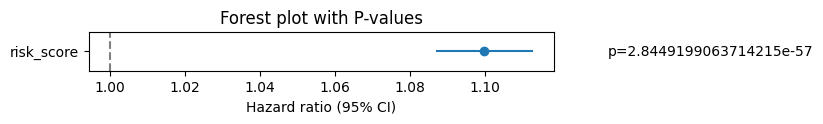

In [86]:
import numpy as np
import matplotlib.pyplot as plt

# Extract summary
summary = cph.summary.reset_index()
hr = summary['exp(coef)']
ci_lower = summary['exp(coef) lower 95%']
ci_upper = summary['exp(coef) upper 95%']
p_vals = summary['p']

# Plot
fig, ax = plt.subplots(figsize=(6, len(hr)*0.5))
y = np.arange(len(hr))
ax.errorbar(hr, y, xerr=[hr-ci_lower, ci_upper-hr], fmt='o')
for i, (p, name) in enumerate(zip(p_vals, summary['covariate'])):
    ax.text(ci_upper[i] + 0.02, i, f"p={p}", va='center')
ax.set_yticks(y)
ax.set_yticklabels(summary['covariate'])
ax.axvline(1, color='grey', linestyle='--')
ax.set_xlabel("Hazard ratio (95% CI)")
ax.set_title("Forest plot with P-values")
plt.tight_layout()
plt.show()


### TMA Corrolations

In [1]:
import pandas as pd
csv_clusters = pd.read_csv("/nfs/home/users/fshahi/Projects/Histomorphological-Phenotype-Learning/results/BarlowTwins_3/Meso/h224_w224_n3_zdim128/750K/adatas/Meso_TMA_he_complete_meta_filtered_leiden_2p0__fold4.csv")
csv_clusters

,ATP5A Cytoplasmic H-Score,ATP5A Positive Tumour Area (%),DDX3X Cytoplasmic H-Score,DDX3X Positive Tumour Area (%),Donor Block Number,HB_score,SDHB Cytoplasmic H-Score,SDHB Positive Tumour Area (%),Stage,TMA Array Number,...,slides,smoking_history,specimen_number,tiles,time_to_recurrence,tma,tmakey,type,wcc_score,leiden_2.0
0,239,44,86,51,11,Low,28,17,IIIA,TMA 2,...,MESO2_3-F,Ex-smoker,PR086235A/14,1_1.jpeg,0,Meso2,MESO2_3-F,Epithelioid,Normal,35
1,0,0,0,0,20,Low,0,0,IIIB,TMA 8,...,MESO8_5-C,Never smoked,PD001467P/05,0_1.jpeg,5,Meso8,MESO8_5-C,Biphasic,Normal,3
2,158,45,0,0,7,Normal,21,22,IB,TMA 1,...,MESO1_10-G,Ex-smoker,NaN,1_2.jpeg,8,Meso1,MESO1_10-G,NaN,Normal,18
3,206,35,216,39,11,Normal,147,41,II,TMA 2,...,MESO2_10-H,NaN,PR080072Z/13,2_1.jpeg,4,Meso2,MESO2_10-H,Epithelioid,Normal,24
4,145,36,0,0,5,Low,56,21,IB,TMA 1,...,MESO1_14-C,Never smoked,PR051093F/14,1_2.jpeg,10,Meso1,MESO1_14-C,Epithelioid,Normal,42
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3585,8,1,0,0,2,Low,2,1,Missing,TMA 1,...,MESO1_11-J,NaN,NaN,0_1.jpeg,1,Meso1,MESO1_11-J,NaN,Normal,12
3586,0,0,107,53,4,Normal,0,0,Missing,TMA 7,...,MESO7_12-E,Ex-smoker,PR015333Z/07,1_2.jpeg,1,Meso7,MESO7_12-E,Epithelioid,Normal,15
3587,236,41,0,0,8,Normal,42,16,IIIA,TMA 1,...,MESO1_5-E,Ex-smoker,NaN,0_2.jpeg,5,Meso1,MESO1_5-E,NaN,Normal,6
3588,0,0,0,0,8,Normal,0,0,Missing,TMA 5,...,MESO5_9-I,NaN,PD002360D-06,0_1.jpeg,1,Meso5,MESO5_9-I,Epithelioid,Normal,6


In [117]:
cluster_counts = pd.crosstab(csv_clusters['slides'], csv_clusters['leiden_2.0'])
# add an epsilon to all zeros
# slides = cluster_counts.index
# columns = list(cluster_counts.columns)
# cluster_counts = cluster_counts.apply(lambda x: x+.0000000000000000000000001)
# temp = clr(cluster_counts)
# cluster_counts = pd.DataFrame(temp,columns=columns )
# cluster_counts.index = slides


metadata_cols = [col for col in csv_clusters.columns if col not in ['leiden_2.0', 'slides', 'samples', 'case', 'case_Id', 'col', 'cols', 'core_type', 'cores', 'donor_block', 'row', 'samples', 'slides','tiles', 'tmakey', 'tma', 'specimen_number', 'patterns', 'original_set', 'labels', 'type', 'Donor Block Number', 'indexes', 'os_event_data']]
slide_metadata = csv_clusters.groupby('samples')[metadata_cols].first() #because slides 
result_df = cluster_counts.join(slide_metadata)
# result_df = result_df.drop('slides')
result_df = result_df.reset_index()
result_df


,slides,0,1,2,3,5,6,7,8,10,...,hist_subtype,ki67 Nuclear H-Score,ki67 Positive Tumour Area (%),os_event_ind,p-S6 Cytoplasmic H-Score,p-S6 Positive Tumour Area (%),recurrence,smoking_history,time_to_recurrence,wcc_score
0,MESO1_10-A,0,0,0,0,0,1,0,0,0,...,train,15,11,Dead,144,29,No Recurrence,Never smoked,1,Normal
1,MESO1_10-B,0,0,0,0,0,0,0,0,0,...,valid,13,8,Dead,186,39,No Recurrence,Ex-smoker,2,Normal
2,MESO1_10-C,0,0,0,0,0,2,0,0,0,...,train,172,90,Dead,95,21,No Recurrence,None,17,Normal
3,MESO1_10-D,0,0,0,0,0,1,0,0,0,...,train,59,38,Dead,127,28,Recurrence,Never smoked,4,Normal
4,MESO1_10-E,0,0,0,0,0,0,0,1,1,...,train,10,6,Dead,34,7,No Recurrence,Ex-smoker,0,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
706,MESO8_9-E,0,0,0,0,0,0,0,0,0,...,train,0,0,Dead,0,0,No Recurrence,Never smoked,0,Normal
707,MESO8_9-G,0,0,0,0,0,0,0,0,0,...,test,0,0,Dead,0,0,No Recurrence,Current,1,High
708,MESO8_9-H,0,0,0,0,0,0,0,4,0,...,train,0,0,Dead,0,0,No Recurrence,Never smoked,1,Normal
709,MESO8_9-I,0,0,0,0,0,0,0,0,0,...,test,0,0,Dead,0,0,No Recurrence,Never smoked,0,Normal


In [ ]:
result_df[cluster_cols].max()

0     5
1     2
2     3
3     3
5     1
6     4
7     3
8     5
10    4
11    4
12    4
13    5
14    3
15    4
16    3
17    3
18    5
19    2
20    5
21    4
22    2
23    6
24    3
25    5
26    3
27    5
28    1
29    3
30    3
31    1
32    1
33    2
34    1
35    4
36    3
37    2
38    3
39    4
40    2
41    3
42    4
43    7
44    5
46    5
dtype: int64

In [118]:
# Now use the function (you'll need to define cluster_cols and metadata_cols)
cluster_cols = [col for col in result_df.columns if isinstance(col, int)]  # Assuming cluster columns are numeric
metadata_cols = [col for col in result_df.columns if col not in cluster_cols and col != 'slides']

In [140]:
metadata_cols

['ATP5A Cytoplasmic H-Score',
 'ATP5A Positive Tumour Area (%)',
 'DDX3X Cytoplasmic H-Score',
 'DDX3X Positive Tumour Area (%)',
 'HB_score',
 'SDHB Cytoplasmic H-Score',
 'SDHB Positive Tumour Area (%)',
 'Stage',
 'TMA Array Number',
 'T_Stage',
 'desmoplastic_component',
 'eif4A1 Cytoplasmic H-Score',
 'eif4A1 Positive Tumour Area (%)',
 'eif4A2 Cytoplasmic H-Score',
 'eif4A2 Positive Tumour Area (%)',
 'hist_subtype',
 'ki67 Nuclear H-Score',
 'ki67 Positive Tumour Area (%)',
 'os_event_ind',
 'p-S6 Cytoplasmic H-Score',
 'p-S6 Positive Tumour Area (%)',
 'recurrence',
 'smoking_history',
 'time_to_recurrence',
 'wcc_score']

Found 12 significant correlations after FDR correction


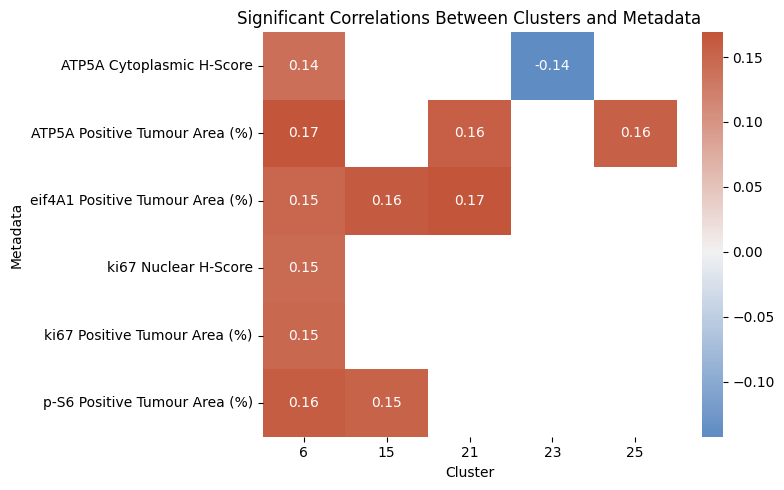

In [136]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from statsmodels.stats.multitest import multipletests

# 1. Create a function to analyze correlations with all metadata variables
def analyze_correlations(result_df, cluster_cols, metadata_cols, method='spearman'):
    results = []
    for meta_col in metadata_cols:
        if result_df[meta_col].dtype in [np.float64, np.int64]:  # Numeric columns only
            for cluster in cluster_cols:
                # Calculate correlation
                if method == 'pearson':
                    corr, p_value = stats.pearsonr(result_df[cluster], result_df[meta_col])
                else:
                    corr, p_value = stats.spearmanr(result_df[cluster], result_df[meta_col])
                results.append({
                    'Metadata': meta_col,
                    'Cluster': cluster,
                    'Correlation': corr,
                    'P-value': p_value
                })
    
    # Create DataFrame from results
    corr_results = pd.DataFrame(results)
    
    # Apply multiple testing correction
    if len(corr_results) > 0:
        _, corr_results['FDR_P_value'], _, _ = multipletests(
            corr_results['P-value'], alpha=0.01, method='fdr_bh')
    
    return corr_results



# Run the analysis
correlation_results = analyze_correlations(result_df, cluster_cols, metadata_cols)
significant_corrs = correlation_results[correlation_results['FDR_P_value'] < 0.01].sort_values('FDR_P_value')
print(f"Found {len(significant_corrs)} significant correlations after FDR correction")

# Visualize top correlations
if len(significant_corrs) > 0:
    plt.figure(figsize=(8,5))
    
    # Create a pivot table for the heatmap
    pivot = significant_corrs.pivot(index='Metadata', columns='Cluster', values='Correlation')
    
    # Create heatmap
    sns.heatmap(pivot, cmap=sns.diverging_palette(250,20, as_cmap=True), center=0, annot=True, fmt='.2f')
    plt.title('Significant Correlations Between Clusters and Metadata')
    plt.tight_layout()
    plt.show()

In [123]:
annot_df = pd.read_csv("/nfs/home/users/fshahi/Projects/Histomorphological-Phenotype-Learning/files/meso_annotations_750K.csv")
annot_df

,Unnamed: 0,HPC,Summary,main_pattern
0,0,0,Talc reaction,Talc
1,1,1,"Inflamed fat, sparse epithelioid nests",Inflamed
2,2,2,Compressed lung,Lung
3,3,3,Sparsely cellular connective tissues,Collagen
4,4,4,"Muscle, crushed",Muscle
5,5,5,Lung with vessels,Lung
6,6,6,Inflamed solid/spindled,Inflamed malignancy
7,7,7,Heavily inflamed diverse malignancy,Inflamed malignancy
8,8,8,"Tubulopapillary epithelioid, cold","Nested epithelioid, cold"
9,9,9,Open lung,Lung


In [120]:
significant_corrs

,Metadata,Cluster,Correlation,P-value,FDR_P_value
49,ATP5A Positive Tumour Area (%),6,0.168980,0.000006,0.001952
327,eif4A1 Positive Tumour Area (%),21,0.168940,0.000006,0.001952
321,eif4A1 Positive Tumour Area (%),15,0.162823,0.000013,0.002821
63,ATP5A Positive Tumour Area (%),21,0.157268,0.000025,0.003133
67,ATP5A Positive Tumour Area (%),25,0.156269,0.000028,0.003133
577,p-S6 Positive Tumour Area (%),6,0.159619,0.000019,0.003133
585,p-S6 Positive Tumour Area (%),15,0.153751,0.000038,0.003619
489,ki67 Positive Tumour Area (%),6,0.147832,0.000076,0.005572
313,eif4A1 Positive Tumour Area (%),6,0.148708,0.000069,0.005572
445,ki67 Nuclear H-Score,6,0.145031,0.000104,0.006868


Found 26 significant correlations after FDR correction


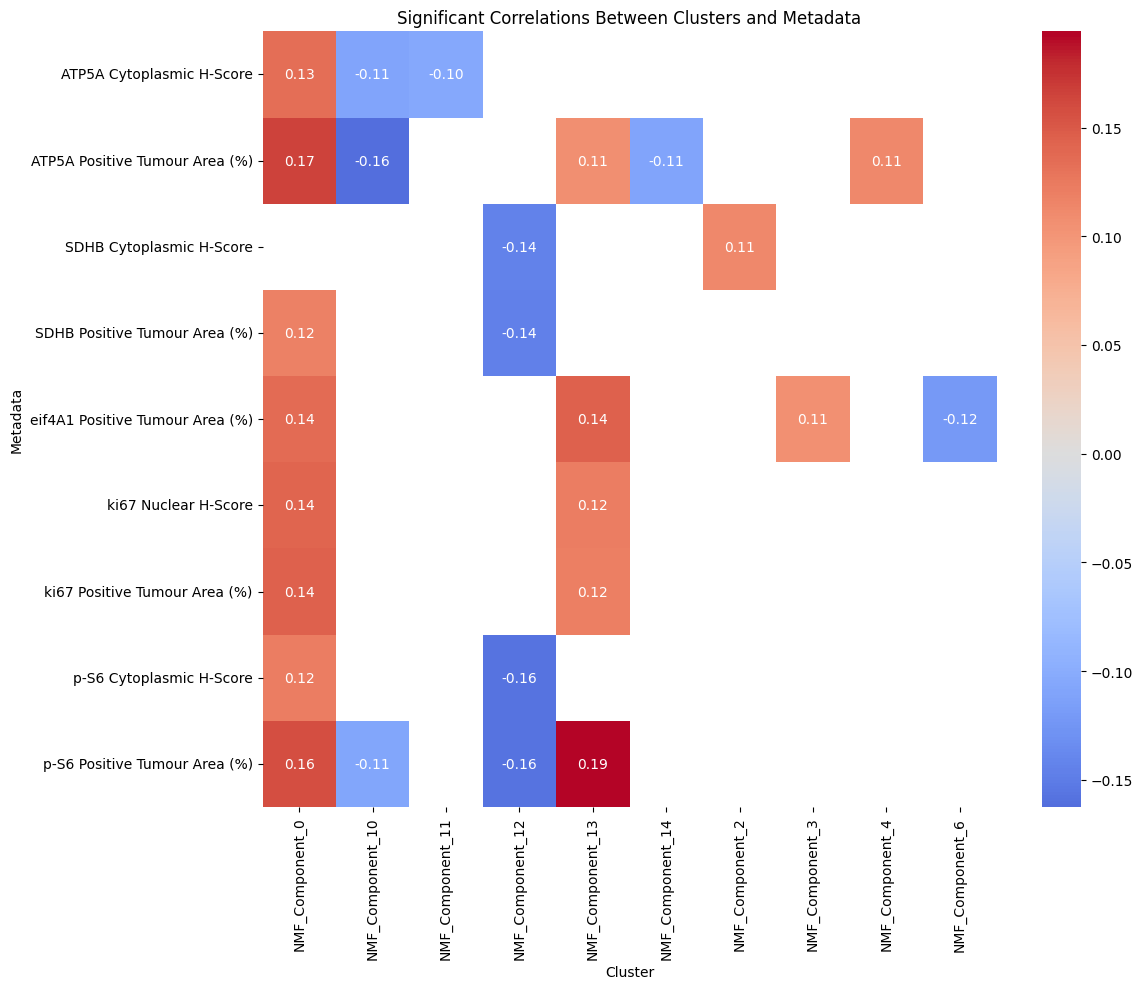

In [83]:
from sklearn.decomposition import NMF

# Extract just the cluster frequency matrix
cluster_matrix = result_df[cluster_cols].values

# Determine number of components to use (could also use a grid search)
n_components = min(15, len(cluster_cols))  # Choose smaller number than original clusters

# Apply NMF
nmf = NMF(n_components=n_components, random_state=42)
nmf_features = nmf.fit_transform(cluster_matrix)

# Create a new DataFrame with these compressed representations
nmf_df = pd.DataFrame(nmf_features, 
                      columns=[f'NMF_Component_{i}' for i in range(n_components)])
                      
# Add the slide ID and metadata back
nmf_df['slides'] = result_df['slides']
for meta_col in metadata_cols:
    nmf_df[meta_col] = result_df[meta_col]

# Now analyze correlations with the NMF components instead
nmf_cluster_cols = [f'NMF_Component_{i}' for i in range(n_components)]
nmf_correlations = analyze_correlations(nmf_df, nmf_cluster_cols, metadata_cols)



# Filter for significant results (FDR-corrected p < 0.05)
significant_corrs = nmf_correlations[nmf_correlations['FDR_P_value'] < 0.05].sort_values('FDR_P_value')
print(f"Found {len(significant_corrs)} significant correlations after FDR correction")

# Visualize top correlations
if len(significant_corrs) > 0:
    plt.figure(figsize=(12, 10))
    
    # Create a pivot table for the heatmap
    pivot = significant_corrs.pivot(index='Metadata', columns='Cluster', values='Correlation')
    
    # Create heatmap
    sns.heatmap(pivot, cmap='coolwarm', center=0, annot=True, fmt='.2f')
    plt.title('Significant Correlations Between Clusters and Metadata')
    plt.tight_layout()
    plt.show()

In [82]:
from sklearn.linear_model import ElasticNet, LogisticRegression
from sklearn.model_selection import cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import permutation_test_score

# For continuous metadata, use regression
def predict_metadata_regression(result_df, cluster_cols, target_col):
    X = result_df[cluster_cols].values
    y = result_df[target_col].values
    
    # Standardize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Use ElasticNet for sparse data
    model = ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=42)
    # model = LogisticRegression(max_iter=1000)
    # Cross-validation
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    cv_scores = cross_val_score(model, X_scaled, y, cv=kfold, scoring='r2')
    
    # Fit on all data to get feature importances
    model.fit(X_scaled, y)
    # print('test_score:', permutation_test_score(model, X, y))
    score, permutation_scores, pvalue = permutation_test_score(model, X, y, random_state=0)
    print(f"Original Score: {score:.3f}")
    print(f"Permutation Scores: {permutation_scores.mean():.3f} +/- "f"{permutation_scores.std():.3f}")
    print(f"P-value: {pvalue:.3f}")

    
    # Get feature importances
    importances = pd.DataFrame({
        'Cluster': cluster_cols,
        'Coefficient': model.coef_,
    }).sort_values('Coefficient', key=abs, ascending=False)
    
    print(f"Cross-validation R² for {target_col}: {np.mean(cv_scores):.4f} ± {np.std(cv_scores):.4f}")    
    return importances, model, cv_scores

for t_c in ['ki67 Nuclear H-Score']:
    importances, model, cv_scores = predict_metadata_regression(result_df, cluster_cols, t_c)

importances, model, cv_scores

Original Score: -0.208
Permutation Scores: -0.045 +/- 0.018
P-value: 1.000
Cross-validation R² for ki67 Nuclear H-Score: 0.0199 ± 0.0185


(    Cluster  Coefficient
 25       27     9.173615
 20       22     5.488359
 6         7     5.395853
 11       13     3.868507
 19       21     3.343095
 5         6     3.205541
 2         2     2.605555
 13       15     2.455381
 23       25     2.317559
 17       19    -2.092626
 14       16    -1.675375
 36       38    -1.599178
 42       44    -1.449025
 28       30     1.249802
 18       20     1.237761
 37       39    -1.125425
 38       40    -1.110154
 4         5    -0.969728
 34       36     0.960847
 15       17    -0.907651
 26       28    -0.817565
 10       12     0.805742
 16       18     0.798085
 7         8    -0.759778
 32       34    -0.751107
 3         3    -0.732961
 22       24     0.718382
 24       26    -0.678447
 31       33    -0.524895
 35       37     0.358618
 30       32    -0.321152
 8        10     0.297785
 33       35    -0.294840
 1         1     0.289309
 39       41    -0.239480
 9        11    -0.143970
 29       31    -0.140944
 27       29

In [74]:
metadata_cols

['ATP5A Cytoplasmic H-Score',
 'ATP5A Positive Tumour Area (%)',
 'DDX3X Cytoplasmic H-Score',
 'DDX3X Positive Tumour Area (%)',
 'HB_score',
 'SDHB Cytoplasmic H-Score',
 'SDHB Positive Tumour Area (%)',
 'Stage',
 'TMA Array Number',
 'T_Stage',
 'desmoplastic_component',
 'eif4A1 Cytoplasmic H-Score',
 'eif4A1 Positive Tumour Area (%)',
 'eif4A2 Cytoplasmic H-Score',
 'eif4A2 Positive Tumour Area (%)',
 'hist_subtype',
 'ki67 Nuclear H-Score',
 'ki67 Positive Tumour Area (%)',
 'os_event_ind',
 'p-S6 Cytoplasmic H-Score',
 'p-S6 Positive Tumour Area (%)',
 'recurrence',
 'smoking_history',
 'time_to_recurrence',
 'wcc_score']